# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 36.8 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=1981

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Parameters:
    -----------
    dcor_df : pandas.DataFrame
        The distance correlation matrix as a pandas DataFrame.

    Returns:
    --------
    Histogram plot of the correlations.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates 10 bins with edges at 0, 0.1, 0.2, ..., 1.0
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")


**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'Attribute1': 'Status_of_existing_checking_account',
    'Attribute2': 'Duration',
    'Attribute3': 'Credit_history',
    'Attribute4': 'Purpose',
    'Attribute5': 'Credit_amount',
    'Attribute6': 'Savings_account_bonds',
    'Attribute7': 'Present_employment_since',
    'Attribute8': 'Installment_rate_in_percentage_of_disposable_income',
    'Attribute9': 'Personal_status_and_sex',
    'Attribute10': 'Other_debtors_guarantors',
    'Attribute11': 'Present_residence_since',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'Other_installment_plans',
    'Attribute15': 'Housing',
    'Attribute16': 'Number_of_existing_credits_at_this_bank',
    'Attribute17': 'Job',
    'Attribute18': 'Number_of_people_being_liable_to_provide_maintenance_for',
    'Attribute19': 'Telephone',
    'Attribute20': 'Foreign_worker',
    'class': 'Target'
}

german_credit, german_variables = load_data_from_ucimlrepo(144, variable_rename_dict=variable_rename)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
german_credit.head()

Status_of_existing_checking_account  Duration Credit_history Purpose  \
0                                 A11         6            A34     A43   
1                                 A12        48            A32     A43   
2                                 A14        12            A34     A46   
3                                 A11        42            A32     A42   
4                                 A11        24            A33     A40   

   Credit_amount Savings_account_bonds Present_employment_since  \
0           1169                   A65                      A75   
1           5951                   A61                      A73   
2           2096                   A61                      A74   
3           7882                   A61                      A74   
4           4870                   A61                      A73   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

  Personal_status_and_sex Other_debtors_guarantors  ...  Property Age  \
0                     A93                     A101  ...      A121  67   
1                     A92                     A101  ...      A121  22   
2                     A93                     A101  ...      A121  49   
3                     A93                     A103  ...      A122  45   
4                     A93                     A101  ...      A124  53   

   Other_installment_plans Housing Number_of_existing_credits_at_this_bank  \
0                     A143    A152                                       2   
1                     A143    A152                                       1   
2                     A143    A152                                       1   
3                     A143    A153                                       1   
4                     A143    A153                                       2   

    Job Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0  A173                                                  1             A192   
1  A173                                                  1             A191   
2  A172                                                  2             A191   
3  A173                                                  2             A191   
4  A173                                                  2             A191   

  Foreign_worker Target  
0           A201      1  
1           A201      2  
2           A201      1  
3           A201      1  
4           A201      2  

[5 rows x 21 columns]

In [ ]:
german_variables

name     role         type  \
0                 Status_of_existing_checking_account  Feature  Categorical   
1                                            Duration  Feature      Integer   
2                                      Credit_history  Feature  Categorical   
3                                             Purpose  Feature  Categorical   
4                                       Credit_amount  Feature      Integer   
5                               Savings_account_bonds  Feature  Categorical   
6                            Present_employment_since  Feature  Categorical   
7   Installment_rate_in_percentage_of_disposable_i...  Feature      Integer   
8                             Personal_status_and_sex  Feature  Categorical   
9                            Other_debtors_guarantors  Feature  Categorical   
10                            Present_residence_since  Feature      Integer   
11                                           Property  Feature  Categorical   
12                                                Age  Feature      Integer   
13                            Other_installment_plans  Feature  Categorical   
14                                            Housing  Feature  Categorical   
15            Number_of_existing_credits_at_this_bank  Feature      Integer   
16                                                Job  Feature  Categorical   
17  Number_of_people_being_liable_to_provide_maint...  Feature      Integer   
18                                          Telephone  Feature       Binary   
19                                     Foreign_worker  Feature       Binary   
20                                             Target   Target       Binary   

       demographic                                        description   units  \
0             None                Status of existing checking account    None   
1             None                                           Duration  months   
2             None                                     Credit history    None   
3             None                                            Purpose    None   
4             None                                      Credit amount    None   
5             None                              Savings account/bonds    None   
6            Other                           Present employment since    None   
7             None  Installment rate in percentage of disposable i...    None   
8   Marital Status                            Personal status and sex    None   
9             None                         Other debtors / guarantors    None   
10            None                            Present residence since    None   
11            None                                           Property    None   
12             Age                                                Age   years   
13            None                            Other installment plans    None   
14           Other                                            Housing    None   
15            None            Number of existing credits at this bank    None   
16      Occupation                                                Job    None   
17            None  Number of people being liable to provide maint...    None   
18            None                                          Telephone    None   
19           Other                                     foreign worker    None   
20            None                                  1 = Good, 2 = Bad    None   

   missing_values  
0              no  
1              no  
2              no  
3              no  
4              no  
5              no  
6              no  
7              no  
8              no  
9              no  
10             no  
11             no  
12             no  
13             no  
14             no  
15             no  
16             no  
17             no  
18             no  
19             no  
20             no

## Make feature names and feature values more human-interpretable

In [ ]:
# Dictionaries for each categorical attribute
Status_of_existing_checking_account = {
    'A11': 'less than 0 DM',
    'A12': 'from 0 to 200 DM',
    'A13': 'greater or equal to 200 DM or salary assignments',
    'A14': 'no checking account'
}

Credit_history = {
    'A30': 'no credits taken or all credits paid back duly',
    'A31': 'all credits at this bank paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account or other credits existing'
}

Purpose = {
    'A40': 'car new',
    'A41': 'car used',
    'A42': 'furniture or equipment',
    'A43': 'radio or television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}

Savings_account_bonds = {
    'A61': 'less than 100 DM',
    'A62': 'from 100 to 500 DM',
    'A63': 'from 500 to 1000 DM',
    'A64': 'greater or equal to 1000 DM',
    'A65': 'unknown/no savings account'
}

Present_employment_since = {
    'A71': 'unemployed',
    'A72': 'less than 1 year',
    'A73': 'from 1 to 4 years',
    'A74': 'from 4 to 7 years',
    'A75': 'greater or equal to 7 years'
}

Personal_status_and_sex = {
    'A91': 'male divorced or separated',
    'A92': 'female divorced or separated or married',
    'A93': 'male single',
    'A94': 'male married or widowed',
    'A95': 'female single'
}

Other_debtors_guarantors = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}

Property = {
    'A121': 'real estate',
    'A122': 'building society savings or agreement or life insurance',
    'A123': 'car or other',
    'A124': 'unknown or no property'
}

Other_installment_plans = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}

Housing = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}

Job = {
    'A171': 'unemployed or unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee or official',
    'A174': 'management or self-employed or highly qualified employee or officer'
}

Telephone = {
    'A191': 'no',
    'A192': 'yes'
}

Foreign_worker = {
    'A201': 'yes',
    'A202': 'no'
}

Target = {
    1: 'good',
    2: 'bad'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'Status_of_existing_checking_account': Status_of_existing_checking_account,
    'Credit_history': Credit_history,
    'Purpose': Purpose,
    'Savings_account_bonds': Savings_account_bonds,
    'Present_employment_since': Present_employment_since,
    'Personal_status_and_sex': Personal_status_and_sex,
    'Other_debtors_guarantors': Other_debtors_guarantors,
    'Property': Property,
    'Other_installment_plans': Other_installment_plans,
    'Housing': Housing,
    'Job': Job,
    'Telephone': Telephone,
    'Foreign_worker': Foreign_worker,
    'Target': Target
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    german_credit[column] = german_credit[column].map(mapping)

german_credit.head()

Status_of_existing_checking_account  Duration  \
0                      less than 0 DM         6   
1                    from 0 to 200 DM        48   
2                 no checking account        12   
3                      less than 0 DM        42   
4                      less than 0 DM        24   

                               Credit_history                 Purpose  \
0  critical account or other credits existing     radio or television   
1    existing credits paid back duly till now     radio or television   
2  critical account or other credits existing               education   
3    existing credits paid back duly till now  furniture or equipment   
4             delay in paying off in the past                 car new   

   Credit_amount       Savings_account_bonds     Present_employment_since  \
0           1169  unknown/no savings account  greater or equal to 7 years   
1           5951            less than 100 DM            from 1 to 4 years   
2           2096            less than 100 DM            from 4 to 7 years   
3           7882            less than 100 DM            from 4 to 7 years   
4           4870            less than 100 DM            from 1 to 4 years   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

                   Personal_status_and_sex Other_debtors_guarantors  ...  \
0                              male single                     none  ...   
1  female divorced or separated or married                     none  ...   
2                              male single                     none  ...   
3                              male single                guarantor  ...   
4                              male single                     none  ...   

                                            Property Age  \
0                                        real estate  67   
1                                        real estate  22   
2                                        real estate  49   
3  building society savings or agreement or life ...  45   
4                             unknown or no property  53   

   Other_installment_plans   Housing Number_of_existing_credits_at_this_bank  \
0                     none       own                                       2   
1                     none       own                                       1   
2                     none       own                                       1   
3                     none  for free                                       1   
4                     none  for free                                       2   

                            Job  \
0  skilled employee or official   
1  skilled employee or official   
2          unskilled - resident   
3  skilled employee or official   
4  skilled employee or official   

  Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0                                                  1              yes   
1                                                  1               no   
2                                                  2               no   
3                                                  2               no   
4                                                  2               no   

  Foreign_worker Target  
0            yes   good  
1            yes    bad  
2            yes   good  
3            yes   good  
4            yes    bad  

[5 rows x 21 columns]

# **Split data in train and test set**

In [ ]:
german_credit_train, german_credit_test = train_test_split(
    german_credit, test_size=0.2, random_state=RANDOM_STATE,
    stratify=german_credit["Target"]
)
german_credit_train['Target'].value_counts()

Target
good    560
bad     240
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = (
    list(german_variables[german_variables['type']=='Binary']['name']) +
    list(german_variables[german_variables['type']=='Categorical']['name'])
)

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
german_credit_train_encoded, german_ohe = one_hot_encoding(german_credit_train, cat_variables, encoder=None)
german_credit_test_encoded, _ = one_hot_encoding(german_credit_test, cat_variables, encoder=german_ohe)

# Traget variable encoding for the project 0: "Good" and 1: "Bad", useful for F1 calculation
Target_encoder = {
    'good': 0.0,
    'bad': 1.0
}
german_credit_train_encoded = encode_binary_variables(german_credit_train_encoded, ['Target'], Target_encoder)
german_credit_test_encoded = encode_binary_variables(german_credit_test_encoded, ['Target'], Target_encoder)

# move target variable to the end of the dataframe
X_vars = [col for col in german_credit_train_encoded.columns if col != 'Target']
german_credit_train_encoded = german_credit_train_encoded[X_vars + ['Target']]
german_credit_test_encoded = german_credit_test_encoded[X_vars + ['Target']]

german_encoded_vars_family = map_encoded_variables_to_original(german_credit_train_encoded.columns, cat_variables)

Categorical variables:  ['Telephone', 'Foreign_worker', 'Status_of_existing_checking_account', 'Credit_history', 'Purpose', 'Savings_account_bonds', 'Present_employment_since', 'Personal_status_and_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job']


In [ ]:
german_credit_train_encoded.head()

Duration  Credit_amount  \
565        24           1553   
747        12           1274   
911        24           4736   
763        21          12680   
723         9            790   

     Installment_rate_in_percentage_of_disposable_income  \
565                                                  3     
747                                                  3     
911                                                  2     
763                                                  4     
723                                                  4     

     Present_residence_since  Age  Number_of_existing_credits_at_this_bank  \
565                        2   23                                        2   
747                        1   37                                        1   
911                        4   25                                        1   
763                        4   30                                        1   
723                        3   66                                        1   

     Number_of_people_being_liable_to_provide_maintenance_for  Telephone_yes  \
565                                                  1                   1.0   
747                                                  1                   0.0   
911                                                  1                   0.0   
763                                                  1                   1.0   
723                                                  1                   0.0   

     Foreign_worker_yes  \
565                 1.0   
747                 1.0   
911                 1.0   
763                 1.0   
723                 1.0   

     Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments  \
565                                                0.0                                      
747                                                0.0                                      
911                                                0.0                                      
763                                                0.0                                      
723                                                0.0                                      

     ...  Property_real estate  Property_unknown or no property  \
565  ...                   0.0                              0.0   
747  ...                   1.0                              0.0   
911  ...                   0.0                              0.0   
763  ...                   0.0                              1.0   
723  ...                   1.0                              0.0   

     Other_installment_plans_none  Other_installment_plans_stores  \
565                           1.0                             0.0   
747                           1.0                             0.0   
911                           0.0                             0.0   
763                           1.0                             0.0   
723                           1.0                             0.0   

     Housing_own  Housing_rent  Job_skilled employee or official  \
565          0.0           1.0                               1.0   
747          1.0           0.0                               0.0   
911          1.0           0.0                               0.0   
763          0.0           0.0                               0.0   
723          1.0           0.0                               0.0   

     Job_unemployed or unskilled - non-resident  Job_unskilled - resident  \
565                                         0.0                       0.0   
747                                         0.0                       1.0   
911                                         0.0                       1.0   
763                                         0.0                       0.0   
723                                         0.0                       1.0   

     Target  
565     0.0  
747     1.0  
911     1.0  
763     1.0  
723     0.0  

[5 r

In [ ]:
german_credit_train_encoded.columns

Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purpose_repairs',

In [ ]:
german_encoded_vars_family

{'Telephone_yes': 'Telephone',
 'Foreign_worker_yes': 'Foreign_worker',
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_less than 0 DM': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_no checking account': 'Status_of_existing_checking_account',
 'Credit_history_critical account or other credits existing': 'Credit_history',
 'Credit_history_delay in paying off in the past': 'Credit_history',
 'Credit_history_existing credits paid back duly till now': 'Credit_history',
 'Credit_history_no credits taken or all credits paid back duly': 'Credit_history',
 'Purpose_car new': 'Purpose',
 'Purpose_car used': 'Purpose',
 'Purpose_domestic appliances': 'Purpose',
 'Purpose_education': 'Purpose',
 'Purpose_furniture or equipment': 'Purpose',
 'Purpose_others': 'Purpose',
 'Purpose_radio or television': 'Purpose',
 'Purpose_repairs': 'Purpose',
 'Purpo

# **Data summary and quality**

In [ ]:
describe_data(german_credit_train_encoded)


Data dimension :
Number of Records :  800 
Number of Features :  49

Datatype of Features :
float64    42
int64       7
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
         Duration  Credit_amount  \
count  800.000000     800.000000   
mean    20.942500    3296.727500   
std     12.163228    2873.973189   
min      4.000000     250.000000   
25%     12.000000    1374.000000   
50%     18.000000    2321.000000   
75%     24.000000    3960.500000   
max     72.000000   18424.000000   

       Installment_rate_in_percentage_of_disposable_income  \
count                                         800.000000     
mean                                            2.967500     
std                                             1.123843     
min                                             1.000000     
25%                                             2.000000     
50%                                 

# **Correlation**

In [ ]:
german_credit_train_encoded.dtypes

Duration                                                                                  int64
Credit_amount                                                                             int64
Installment_rate_in_percentage_of_disposable_income                                       int64
Present_residence_since                                                                   int64
Age                                                                                       int64
Number_of_existing_credits_at_this_bank                                                   int64
Number_of_people_being_liable_to_provide_maintenance_for                                  int64
Telephone_yes                                                                           float64
Foreign_worker_yes                                                                      float64
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    float64
Status_of_existing_checking_account_less than 0 DM                                      float64
Status_of_existing_checking_account_no checking account                                 float64
Credit_history_critical account or other credits existing                               float64
Credit_history_delay in paying off in the past                                          float64
Credit_history_existing credits paid back duly till now                                 float64
Credit_history_no credits taken or all credits paid back duly                           float64
Purpose_car new                                                                         float64
Purpose_car used                                                                        float64
Purpose_domestic appliances                                                             float64
Purpose_education                                                                       float64
Purpose_furniture or equipment                                                          float64
Purpose_others                                                                          float64
Purpose_radio or television                                                             float64
Purpose_repairs                                                                         float64
Purpose_retraining                                                                      float64
Savings_account_bonds_from 500 to 1000 DM                                               float64
Savings_account_bonds_greater or equal to 1000 DM                                       float64
Savings_account_bonds_less than 100 DM                                                  float64
Savings_account_bonds_unknown/no savings account                                        float64
Present_employment_since_from 4 to 7 years                                              float64
Present_employment_since_greater or equal to 7 years                                    float64
Present_employment_since_less than 1 year                                               float64
Present_employment_since_unemployed                                                     float64
Personal_status_and_sex_male divorced or separated                                      float64
Personal_status_and_sex_male married or widowed                                         float64
Personal_status_and_sex_male single                                                     float64
Other_debtors_guarantors_guarantor                                                      float64
Other_debtors_guarantors_none                                                           float64
Property_car or other                                                                   float64
Property_real estate                                                                    float64
Property_unknown or no property                                                         float64
Other_installment_plans_none                                    

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

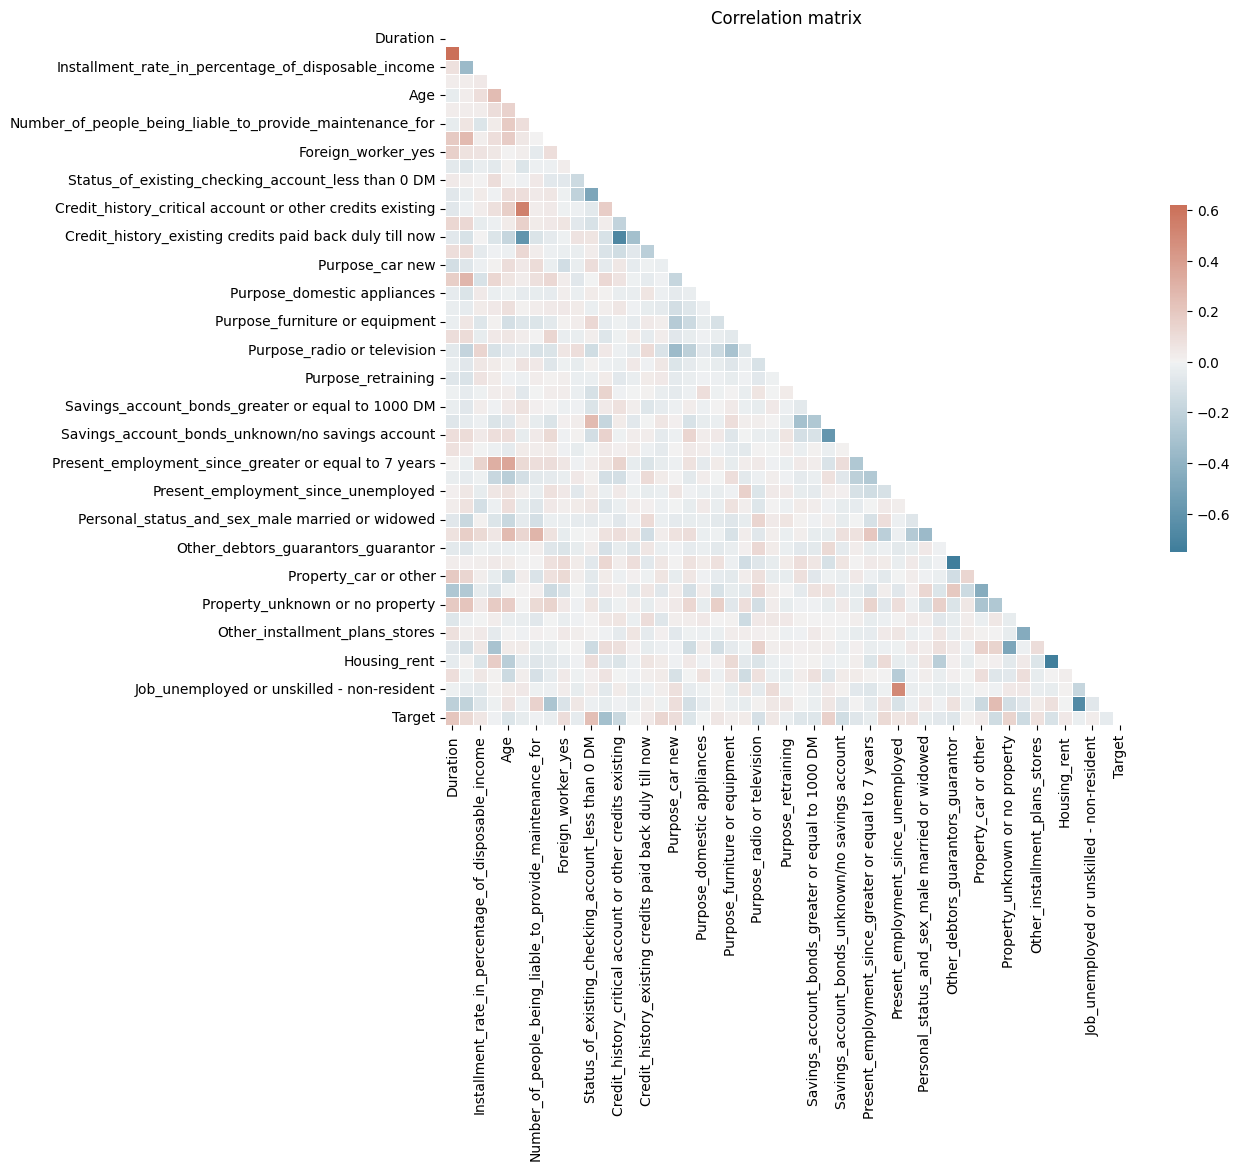

In [ ]:
german_corr = calculate_correlation(german_credit_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(german_corr['Target']).sort_values(ascending=False)

Target                                                                                  1.000000
Status_of_existing_checking_account_no checking account                                 0.322517
Status_of_existing_checking_account_less than 0 DM                                      0.243517
Duration                                                                                0.207344
Credit_history_critical account or other credits existing                               0.167868
Savings_account_bonds_less than 100 DM                                                  0.154313
Other_installment_plans_none                                                            0.148797
Property_unknown or no property                                                         0.142365
Property_real estate                                                                    0.140244
Savings_account_bonds_unknown/no savings account                                        0.138030
Credit_history_no credits taken or all credits paid back duly                           0.132514
Purpose_radio or television                                                             0.114103
Credit_amount                                                                           0.113797
Present_employment_since_less than 1 year                                               0.112393
Housing_own                                                                             0.102062
Foreign_worker_yes                                                                      0.100504
Purpose_car new                                                                         0.097983
Age                                                                                     0.086297
Purpose_car used                                                                        0.084094
Personal_status_and_sex_male divorced or separated                                      0.082880
Savings_account_bonds_greater or equal to 1000 DM                                       0.079224
Savings_account_bonds_from 500 to 1000 DM                                               0.078881
Other_installment_plans_stores                                                          0.076627
Present_employment_since_from 4 to 7 years                                              0.075673
Other_debtors_guarantors_guarantor                                                      0.070758
Present_employment_since_unemployed                                                     0.061685
Personal_status_and_sex_male single                                                     0.060312
Installment_rate_in_percentage_of_disposable_income                                     0.057513
Purpose_education                                                                       0.053813
Job_unskilled - resident                                                                0.048649
Purpose_repairs                                                                         0.047822
Housing_rent                                                                            0.045355
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    0.045075
Credit_history_existing credits paid back duly till now                                 0.044262
Property_car or other                                                                   0.041688
Present_employment_since_greater or equal to 7 years                                    0.039620
Number_of_existing_credits_at_this_bank                                                 0.038184
Personal_status_and_sex_male married or widowed                                         0.035351
Purpose_retraining                                                                      0.032218
Purpose_others                                                                          0.031417
Job_unemployed or unskilled - non-resident                                              0.030165
Telephone_yes          

df columns:  Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purp

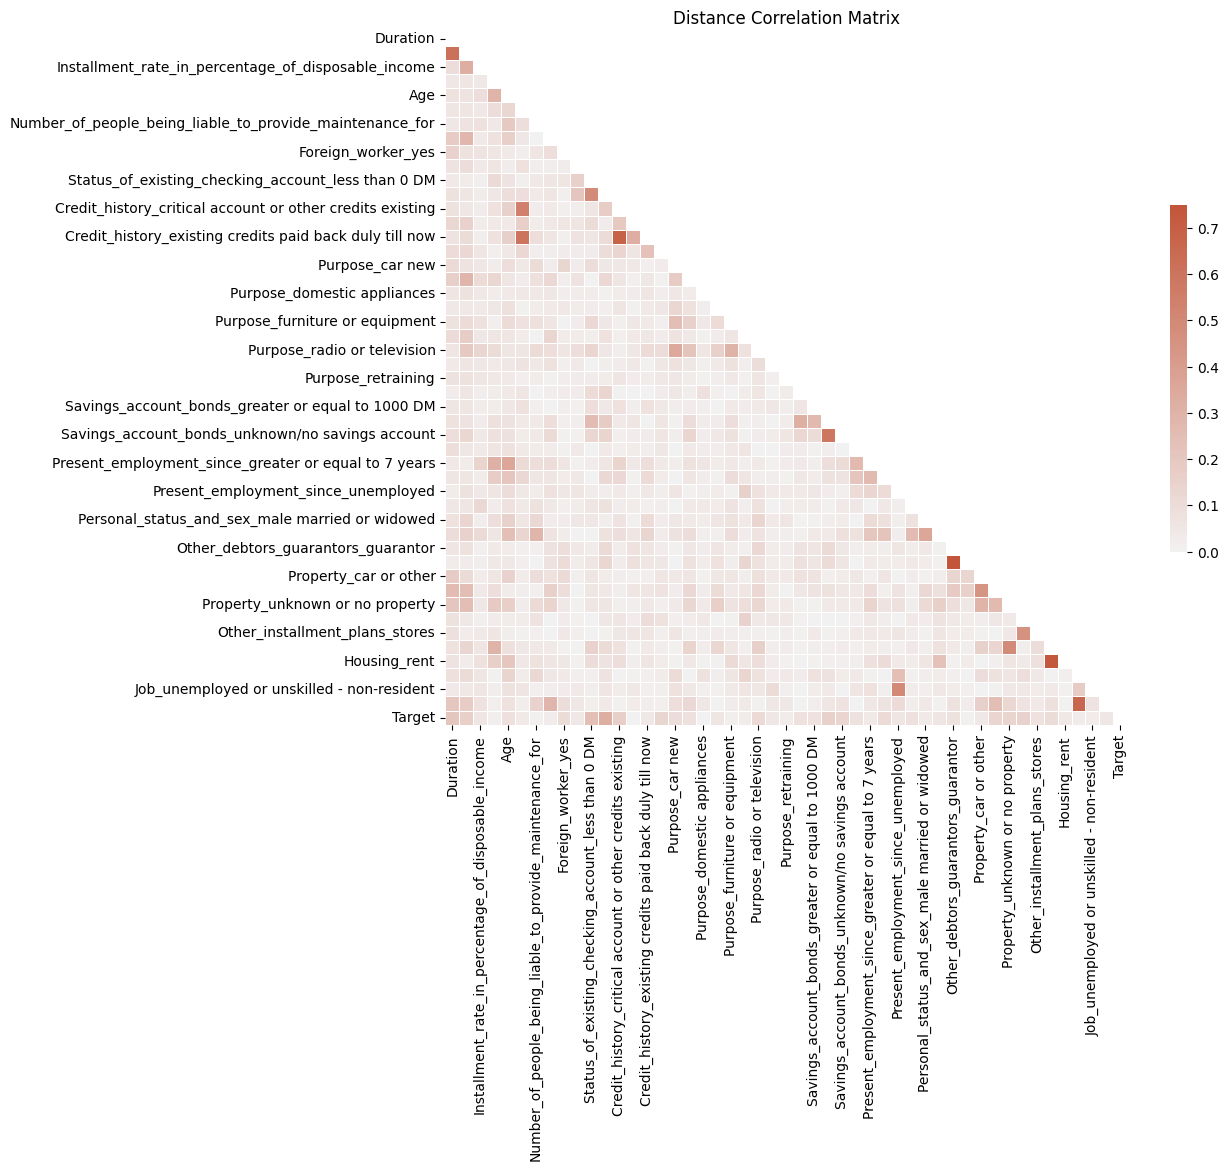

In [ ]:
german_dist_corr = calculate_distance_correlation_matrix(german_credit_train_encoded)

In [ ]:
german_dist_corr['Target'].sort_values(ascending=False)

Target                                                                                  1.000000
Status_of_existing_checking_account_no checking account                                 0.322517
Status_of_existing_checking_account_less than 0 DM                                      0.243517
Duration                                                                                0.207713
Credit_amount                                                                           0.168088
Credit_history_critical account or other credits existing                               0.167868
Savings_account_bonds_less than 100 DM                                                  0.154313
Other_installment_plans_none                                                            0.148797
Property_unknown or no property                                                         0.142365
Property_real estate                                                                    0.140244
Savings_account_bonds_unknown/no savings account                                        0.138030
Credit_history_no credits taken or all credits paid back duly                           0.132514
Purpose_radio or television                                                             0.114103
Present_employment_since_less than 1 year                                               0.112393
Housing_own                                                                             0.102062
Foreign_worker_yes                                                                      0.100504
Purpose_car new                                                                         0.097983
Age                                                                                     0.085061
Purpose_car used                                                                        0.084094
Personal_status_and_sex_male divorced or separated                                      0.082880
Savings_account_bonds_greater or equal to 1000 DM                                       0.079224
Savings_account_bonds_from 500 to 1000 DM                                               0.078881
Other_installment_plans_stores                                                          0.076627
Present_employment_since_from 4 to 7 years                                              0.075673
Other_debtors_guarantors_guarantor                                                      0.070758
Present_employment_since_unemployed                                                     0.061685
Personal_status_and_sex_male single                                                     0.060312
Installment_rate_in_percentage_of_disposable_income                                     0.056997
Purpose_education                                                                       0.053813
Job_unskilled - resident                                                                0.048649
Purpose_repairs                                                                         0.047822
Housing_rent                                                                            0.045355
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    0.045075
Credit_history_existing credits paid back duly till now                                 0.044262
Property_car or other                                                                   0.041688
Present_employment_since_greater or equal to 7 years                                    0.039620
Number_of_existing_credits_at_this_bank                                                 0.037922
Personal_status_and_sex_male married or widowed                                         0.035351
Purpose_retraining                                                                      0.032218
Purpose_others                                                                          0.031417
Job_unemployed or unskilled - non-resident                                              0.030165
Telephone_yes          

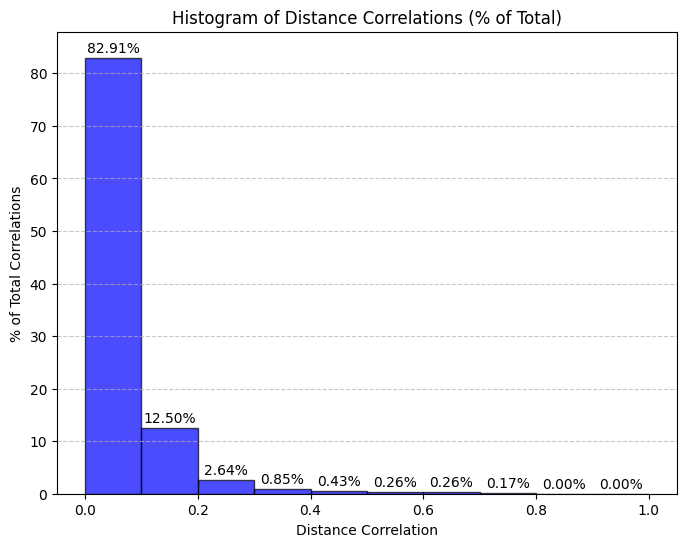

Percentage of correlations below 0.1: 82.91%
Percentage of correlations below 0.2: 95.41%
Percentage of correlations below 0.3: 98.04%
Percentage of correlations below 0.4: 98.89%
Percentage of correlations below 0.5: 99.32%
Percentage of correlations below 0.6: 99.57%
Percentage of correlations below 0.7: 99.83%
Percentage of correlations below 0.8: 100.00%
Percentage of correlations below 0.9: 100.00%
Percentage of correlations below 1.0: 100.00%


In [ ]:
plot_dcor_histogram(german_dist_corr)

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.05

german_zero_variance_columns = identify_zero_variance_columns(german_credit_train_encoded)

if DROP_WEAK_FEATURES:
  german_weak_features = identify_weak_associated_features(
      german_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  german_weak_features = []

remove_columns = set(german_zero_variance_columns + german_weak_features)
print(remove_columns)

german_credit_train = german_credit_train_encoded.drop(columns=remove_columns)
german_credit_test = german_credit_test_encoded.drop(columns=remove_columns)

Variance of each column:
Duration                                                                                1.479441e+02
Credit_amount                                                                           8.259722e+06
Installment_rate_in_percentage_of_disposable_income                                     1.263023e+00
Present_residence_since                                                                 1.232635e+00
Age                                                                                     1.236420e+02
Number_of_existing_credits_at_this_bank                                                 3.186342e-01
Number_of_people_being_liable_to_provide_maintenance_for                                1.387844e-01
Telephone_yes                                                                           2.395354e-01
Foreign_worker_yes                                                                      3.613892e-02
Status_of_existing_checking_account_greater or equal to 200 DM or 

In [ ]:
print('Original number of encoded features: ', len(german_credit_train_encoded.columns))
print('Number of features after pre-feature selection: ', len(german_credit_train.columns))

Original number of encoded features:  49
Number of features after pre-feature selection:  49


# **Imbalanced dataset**

In [ ]:
X_train = german_credit_train.drop('Target', axis=1)
y_train = german_credit_train['Target']

X_test = german_credit_test.drop('Target', axis=1)
y_test = german_credit_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0       560         0.7
1.0       240         0.3

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
german_imputation_values_dict = calculate_imputation_values_for_missing(
    german_credit_train
)
german_imputation_values_dict

{'Duration': 18.0,
 'Credit_amount': 2321.0,
 'Installment_rate_in_percentage_of_disposable_income': 3.0,
 'Present_residence_since': 3.0,
 'Age': 33.0,
 'Number_of_existing_credits_at_this_bank': 1.0,
 'Number_of_people_being_liable_to_provide_maintenance_for': 1.0,
 'Telephone_yes': 0.0,
 'Foreign_worker_yes': 1.0,
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 0.0,
 'Status_of_existing_checking_account_less than 0 DM': 0.0,
 'Status_of_existing_checking_account_no checking account': 0.0,
 'Credit_history_critical account or other credits existing': 0.0,
 'Credit_history_delay in paying off in the past': 0.0,
 'Credit_history_existing credits paid back duly till now': 1.0,
 'Credit_history_no credits taken or all credits paid back duly': 0.0,
 'Purpose_car new': 0.0,
 'Purpose_car used': 0.0,
 'Purpose_domestic appliances': 0.0,
 'Purpose_education': 0.0,
 'Purpose_furniture or equipment': 0.0,
 'Purpose_others': 0.0,
 'Purpose_radio or telev

In [ ]:
german_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
german_cat_vars

['Number_of_people_being_liable_to_provide_maintenance_for',
 'Telephone_yes',
 'Foreign_worker_yes',
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
 'Status_of_existing_checking_account_less than 0 DM',
 'Status_of_existing_checking_account_no checking account',
 'Credit_history_critical account or other credits existing',
 'Credit_history_delay in paying off in the past',
 'Credit_history_existing credits paid back duly till now',
 'Credit_history_no credits taken or all credits paid back duly',
 'Purpose_car new',
 'Purpose_car used',
 'Purpose_domestic appliances',
 'Purpose_education',
 'Purpose_furniture or equipment',
 'Purpose_others',
 'Purpose_radio or television',
 'Purpose_repairs',
 'Purpose_retraining',
 'Savings_account_bonds_from 500 to 1000 DM',
 'Savings_account_bonds_greater or equal to 1000 DM',
 'Savings_account_bonds_less than 100 DM',
 'Savings_account_bonds_unknown/no savings account',
 'Present_employment_since_from 4 t

In [ ]:
# Maximum number of original features to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 0.005, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
      'max_depth': [3],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.01]
  }

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:19:43.376777

Nested Cross-validation Results:
Individual scores: [0.58914729 0.56934307 0.56737589 0.4742268  0.58992806]
Average nested CV score: 0.558 (+/- 0.086)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.558

Train score: 0.606
Test score: 0.558
Train-test score difference: 0.048
2025-01-19 00:19:46.280612

Execution time: 0.05 minutes




```
Starting hyperparameter tuning at: 2025-01-15 03:46:58.096515

Nested Cross-validation Results:
Individual scores: [0.43859649 0.54961832 0.53623188 0.52427184 0.54135338]
Average nested CV score: 0.518 (+/- 0.081)

Fitting final model on entire dataset...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.558

Train score: 0.606
Test score: 0.558
Train-test score difference: 0.048
2025-01-15 03:47:23.190149

Execution time: 0.42 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.155527  0.010253
41                       Other_installment_plans_none    0.034524  0.003807
36                 Other_debtors_guarantors_guarantor    0.017503  0.002115
4                                                 Age    0.007059  0.000627
0                                            Duration    0.005887  0.003444

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

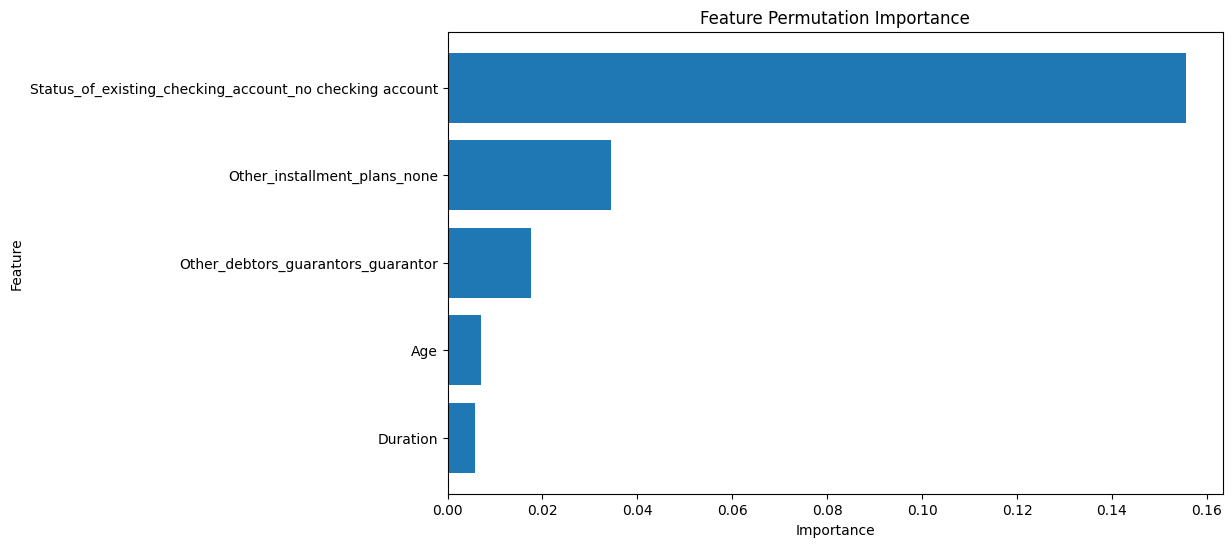

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_plans_stores']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Other_installment_plans']

--- NEW ITERATION ---
Removing feature:  Other_debtors_guarantors_guarantor
Removing related features:  ['Other_debtors_guarantors_guarantor', 'Other_debtors_guarantors_none']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Other_installment_plans', 'Other_debtors_guarantors']

--- NEW ITERATION ---
Removing fe

In [ ]:
dt_orig_missing

['Status_of_existing_checking_account',
 'Other_installment_plans',
 'Other_debtors_guarantors',
 'Age',
 'Duration',
 'Savings_account_bonds',
 'Present_employment_since',
 'Personal_status_and_sex',
 'Property',
 'Job',
 'Housing',
 'Purpose',
 'Credit_history',
 'Present_residence_since',
 'Number_of_existing_credits_at_this_bank',
 'Number_of_people_being_liable_to_provide_maintenance_for',
 'Telephone',
 'Foreign_worker',
 'Installment_rate_in_percentage_of_disposable_income',
 'Credit_amount']

In [ ]:
len(dt_missing)

48

In [ ]:
dt_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   51  63   77   9      39.84   85.00        45.00      57.0     54.26   
1   59   3  137   1      30.10   98.33         2.14      31.0     46.09   
2   59   3  137   1      30.10   98.33         2.14      31.0     46.09   
3   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               65.00                 0   
1               50.24                 1   
2               50.24                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:20:03.806448

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
dt_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   51  63   77   9      39.84   85.00        45.00      57.0     54.26   
1   45  50   90  15      33.33   75.00        35.71      47.5     46.15   
2   45  55   85  15      34.62   75.00        39.29      50.0     47.37   
3   46  51   89  14      34.07   76.67        36.43      48.5     47.18   
4   46  52   88  14      34.33   76.67        37.14      49.0     47.42   
5   46  51   89  14      34.07   76.67        36.43      48.5     47.18   
6   53  31  109   7      32.72   88.33        22.14      42.0     47.75   
7   54  33  107   6      33.54   90.00        23.57      43.5     48.87   
8   55  36  104   5      34.59   91.67        25.71      45.5     50.23   
9   57  30  110   3      34.13   95.00        21.43      43.5     50.22   
10  57  25  115   3      33.14   95.00        17.86      41.0     49.14   
11  54  26  114   6      32.14   90.00        18.57      40.0     47.37   
12  56  30  110   4      33.73   93.33        21.43      43.0     49.56   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  58   5  135   2      30.05   96.67         3.57      31.5     45.85   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               65.00                 0   
1               55.36                 1   
2               57.14                 2   
3               56.55                 3   
4               56.90                 4   
5               56.55                 5   
6               55.24                 6   
7               56.79                 7   
8               58.69                 8   
9               58.21                 9   
10              56.43                10   
11              54.29                11   
12              57.38                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.12                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 2],
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 1]
  }
else:
  # best model
  rf_param_grid = {
      'n_estimators': [300],
      'max_features': ['sqrt'],
      'min_samples_split': [0.1],
      'min_samples_leaf': [0.01],
      'max_depth': [3]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(rf_classifier, rf_param_grid, 5, 5, 'f1', X_train, y_train)

Starting hyperparameter tuning at: 2025-01-19 00:22:50.589387

Nested Cross-validation Results:
Individual scores: [0.54545455 0.61538462 0.6446281  0.65546218 0.62068966]
Average nested CV score: 0.616 (+/- 0.077)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.1, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.616

Train score: 0.654
Test score: 0.616
Train-test score difference: 0.038
2025-01-19 00:22:56.982511

Execution time: 0.11 minutes



```
Starting hyperparameter tuning at: 2025-01-15 03:47:24.742698

Nested Cross-validation Results:
Individual scores: [0.55172414 0.59649123 0.61788618 0.59375    0.62264151]
Average nested CV score: 0.596 (+/- 0.050)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.1, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.616

Train score: 0.654
Test score: 0.616
Train-test score difference: 0.038
2025-01-15 04:23:33.019230

Execution time: 36.14 minutes
```





In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.088766  0.015003
0                                            Duration    0.029012  0.009669
1                                       Credit_amount    0.025640  0.005502
28   Savings_account_bonds_unknown/no savings account    0.014994  0.004970
41                       Other_installment_plans_none    0.014255  0.002500
4                                                 Age    0.012380  0.004495
27             Savings_account_bonds_less than 100 DM    0.011459  0.004072
39                               Property_real estate    0.010751  0.004544
22                        Purpose_radio or television    0.009334  0.001068
40                    Property_unknown or no property    0.006335  0.003845
2   Installment_rate_in_percentage_of_disposable_i...    0.005809  0.002637
12  Credit_history_critical account or other credi...    0.005596  0.005738
10  Status_of_existing_checking_account_less than ...    0.005174  0.005156
3                             Present_residence_since    0.004629  0.002388
36                 Other_debtors_guarantors_guarantor    0.004155  0.001664
29         Present_employment_since_from 4 to 7 years    0.004102  0.002640
31          Present_employment_since_less than 1 year    0.003963  0.001533
26  Savings_account_bonds_greater or equal to 1000 DM    0.003295  0.001010
47                           Job_unskilled - resident    0.003250  0.002103
37                      Other_debtors_guarantors_none    0.002931  0.000902
8                                  Foreign_worker_yes    0.002499  0.001792
34    Personal_status_and_sex_male married or widowed    0.002176  0.001396
32                Present_employment_since_unemployed    0.002025  0.001095
16                                    Purpose_car new    0.002001  0.000767
38                              Property_car or other    0.001767  0.002499
14  Credit_history_existing credits paid back duly...    0.001551  0.001333
44                                       Housing_rent    0.001490  0.000895
17                                   Purpose_car used    0.001136  0.003051
7                                       Telephone_yes    0.001100  0.000716
6   Number_of_people_being_liable_to_provide_maint...    0.000905  0.001108
9   Status_of_existing_checking_account_greater or...    0.000864  0.000432
30  Present_employment_since_greater or equal to 7...    0.000452  0.000905
23                                    Purpose_repairs    0.000432  0.000529
45                   Job_skilled employee or official    0.000197  0.001080
33  Personal_status_and_sex_male divorced or separ...    0.000002  0.001428
13     Credit_history_delay in paying off in the past   -0.000217  0.000433
25          Savings_account_bonds_from 500 to 1000 DM   -0.000230  0.002522
42                     Other_installment_plans_stores   -0.000451  0.000902
35                Personal_status_and_sex_male single   -0.000489  0.002677
15  Credit_history_no credits taken or all credits...   -0.001388  0.001292
43                                        Housing_own   -0.001410  0.003224
5             Number_of_existing_credits_at_this_bank   -0.001569  0.001341
20                     Purpose_furniture or equipment   -0.002471  0.000434

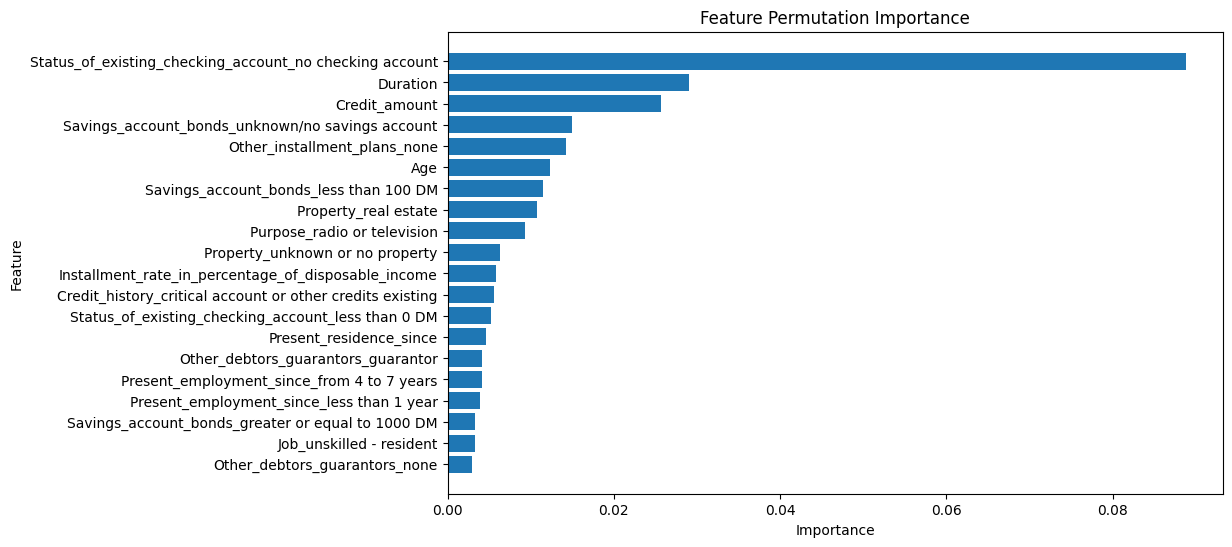

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_unknown/no savings account
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']

In [ ]:
rf_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   47  92   48  13      49.47   78.33        65.71      69.5     60.65   
1   50  61   79  10      38.76   83.33        43.57      55.5     52.91   
2   52  52   88   8      37.14   86.67        37.14      52.0     52.00   
3   50  61   79  10      38.76   83.33        43.57      55.5     52.91   
4   58  36  104   2      35.80   96.67        25.71      47.0     52.25   
5   57  38  102   3      35.85   95.00        27.14      47.5     52.05   
6   57  29  111   3      33.93   95.00        20.71      43.0     50.00   
7   58  25  115   2      33.53   96.67        17.86      41.5     49.79   
8   57  12  128   3      30.81   95.00         8.57      34.5     46.53   
9   57  14  126   3      31.15   95.00        10.00      35.5     46.91   
10  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
11  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
12  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.02                 0   
1               63.45                 1   
2               61.90                 2   
3               63.45                 3   
4               61.19                 4   
5               61.07                 5   
6               57.86                 6   
7               57.26                 7   
8               51.79                 8   
9               52.50                 9   
10              50.36                10   
11              50.36                11   
12              50.36                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:23:01.029158

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
rf_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   47  92   48  13      49.47   78.33        65.71      69.5     60.65   
1   42  77   63  18      40.00   70.00        55.00      59.5     50.91   
2   42  73   67  18      38.53   70.00        52.14      57.5     49.70   
3   40  74   66  20      37.74   66.67        52.86      57.0     48.19   
4   52  44   96   8      35.14   86.67        31.43      48.0     50.00   
5   52  45   95   8      35.37   86.67        32.14      48.5     50.24   
6   52  42   98   8      34.67   86.67        30.00      47.0     49.52   
7   50  40  100  10      33.33   83.33        28.57      45.0     47.62   
8   52  38  102   8      33.77   86.67        27.14      45.0     48.60   
9   51  36  104   9      32.90   85.00        25.71      43.5     47.44   
10  48  27  113  12      29.81   80.00        19.29      37.5     43.44   
11  48  26  114  12      29.63   80.00        18.57      37.0     43.24   
12  48  29  111  12      30.19   80.00        20.71      38.5     43.84   
13  52   5  135   8      27.81   86.67         3.57      28.5     42.11   
14  59   4  136   1      30.26   98.33         2.86      31.5     46.27   
15  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.02                 0   
1               62.50                 1   
2               61.07                 2   
3               59.76                 3   
4               59.05                 4   
5               59.40                 5   
6               58.33                 6   
7               55.95                 7   
8               56.90                 8   
9               55.36                 9   
10              49.64                10   
11              49.29                11   
12              50.36                12   
13              45.12                13   
14              50.60                14   
15              50.95                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

2.3333333333333335

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [40, 8, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'min_child_samples': [8],
    'min_split_gain': [1.0],
    'reg_lambda': [0.0]
}

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:25:47.999957

Nested Cross-validation Results:
Individual scores: [0.56637168 0.58181818 0.5982906  0.61666667 0.68421053]
Average nested CV score: 0.609 (+/- 0.082)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 8, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.609

Train score: 0.733
Test score: 0.609
Train-test score difference: 0.123
2025-01-19 00:25:49.814818

Execution time: 0.03 minutes


```
Starting hyperparameter tuning at: 2025-01-15 04:23:35.247828

Nested Cross-validation Results:
Individual scores: [0.53913043 0.54385965 0.59259259 0.57657658 0.69811321]
Average nested CV score: 0.590 (+/- 0.115)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 8, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.609

Train score: 0.733
Test score: 0.609
Train-test score difference: 0.123
2025-01-15 04:26:32.348068

Execution time: 2.95 minutes
```





In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.097230  0.007643
1                                       Credit_amount    0.064162  0.005355
0                                            Duration    0.029310  0.009023
4                                                 Age    0.022658  0.007550
41                       Other_installment_plans_none    0.020047  0.007400
16                                    Purpose_car new    0.018815  0.004000
12  Credit_history_critical account or other credi...    0.016309  0.003188
36                 Other_debtors_guarantors_guarantor    0.013594  0.003590
8                                  Foreign_worker_yes    0.012654  0.002009
27             Savings_account_bonds_less than 100 DM    0.010971  0.003924
17                                   Purpose_car used    0.010962  0.003960
29         Present_employment_since_from 4 to 7 years    0.009195  0.003731
28   Savings_account_bonds_unknown/no savings account    0.008581  0.003610
26  Savings_account_bonds_greater or equal to 1000 DM    0.008577  0.004319
10  Status_of_existing_checking_account_less than ...    0.008266  0.002542
2   Installment_rate_in_percentage_of_disposable_i...    0.007347  0.005469
19                                  Purpose_education    0.005693  0.001733
22                        Purpose_radio or television    0.004446  0.003548
40                    Property_unknown or no property    0.004445  0.002146
7                                       Telephone_yes    0.004255  0.000532
23                                    Purpose_repairs    0.002968  0.000602
39                               Property_real estate    0.002922  0.004696
32                Present_employment_since_unemployed    0.002320  0.001308
15  Credit_history_no credits taken or all credits...    0.001031  0.001361
35                Personal_status_and_sex_male single    0.000985  0.000492
43                                        Housing_own    0.000738  0.000983
3                             Present_residence_since    0.000633  0.001590
33  Personal_status_and_sex_male divorced or separ...    0.000142  0.002834
31          Present_employment_since_less than 1 year   -0.000846  0.001288
9   Status_of_existing_checking_account_greater or...   -0.002862  0.002353

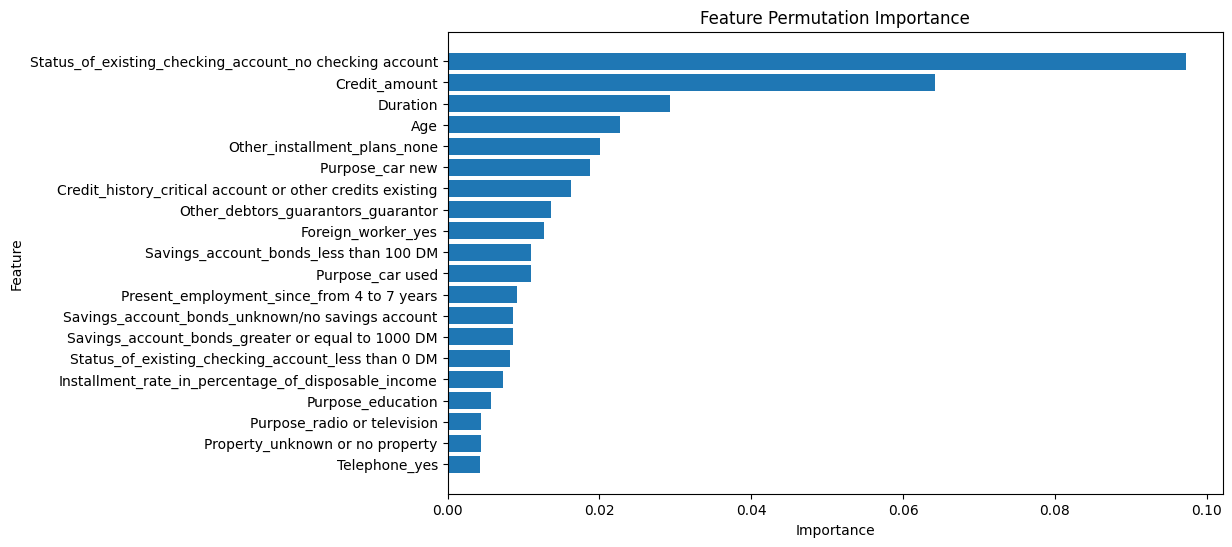

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_pl

In [ ]:
gbt_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  100   40  15      52.94   75.00        71.43      72.5     62.07   
1   51   69   71   9      41.80   85.00        49.29      60.0     56.04   
2   49   79   61  11      44.55   81.67        56.43      64.0     57.65   
3   50   65   75  10      40.00   83.33        46.43      57.5     54.05   
4   51   57   83   9      38.06   85.00        40.71      54.0     52.58   
5   50   60   80  10      38.46   83.33        42.86      55.0     52.63   
6   50   47   93  10      34.97   83.33        33.57      48.5     49.26   
7   50   39  101  10      33.11   83.33        27.86      44.5     47.39   
8   51   36  104   9      32.90   85.00        25.71      43.5     47.44   
9   53   33  107   7      33.12   88.33        23.57      43.0     48.18   
10  59   10  130   1      31.22   98.33         7.14      34.5     47.39   
11  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.21                 0   
1               67.14                 1   
2               69.05                 2   
3               64.88                 3   
4               62.86                 4   
5               63.10                 5   
6               58.45                 6   
7               55.60                 7   
8               55.36                 8   
9               55.95                 9   
10              52.74                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:25:50.907841

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
gbt_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  100   40  15      52.94   75.00        71.43      72.5     62.07   
1   42   86   54  18      43.75   70.00        61.43      64.0     53.85   
2   40   82   58  20      40.82   66.67        58.57      61.0     50.63   
3   39   87   53  21      42.39   65.00        62.14      63.0     51.32   
4   38   81   59  22      39.18   63.33        57.86      59.5     48.41   
5   39   84   56  21      41.05   65.00        60.00      61.5     50.32   
6   39   80   60  21      39.39   65.00        57.14      59.5     49.06   
7   43   69   71  17      37.72   71.67        49.29      56.0     49.43   
8   42   69   71  18      37.17   70.00        49.29      55.5     48.55   
9   44   67   73  16      37.61   73.33        47.86      55.5     49.72   
10  52   39  101   8      33.99   86.67        27.86      45.5     48.83   
11  52   25  115   8      31.14   86.67        17.86      38.5     45.81   
12  50   31  109  10      31.45   83.33        22.14      40.5     45.66   
13  50   20  120  10      29.41   83.33        14.29      35.0     43.48   
14  47   35  105  13      30.92   78.33        25.00      41.0     44.34   
15  32   44   96  28      25.00   53.33        31.43      38.0     34.04   
16  37   52   88  23      29.60   61.67        37.14      44.5     40.00   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.21                 0   
1               65.71                 1   
2               62.62                 2   
3               63.57                 3   
4               60.60                 4   
5               62.50                 5   
6               61.07                 6   
7               60.48                 7   
8               59.64                 8   
9               60.60                 9   
10              57.26                10   
11              52.26                11   
12              52.74                12   
13              48.81                13   
14              51.67                14   
15              42.38                15   
16              49.40                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # Best model
  xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [0.0],
    'colsample_bytree':[0.25]
}

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:28:38.445921

Nested Cross-validation Results:
Individual scores: [0.6        0.58119658 0.58928571 0.5862069  0.66071429]
Average nested CV score: 0.603 (+/- 0.059)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.603

Train score: 0.735
Test score: 0.603
Train-test score difference: 0.131
2025-01-19 00:28:39.447508

Execution time: 0.02 minutes


```
Starting hyperparameter tuning at: 2025-01-15 04:26:32.357050

Nested Cross-validation Results:
Individual scores: [0.6        0.51376147 0.5840708  0.61666667 0.61682243]
Average nested CV score: 0.586 (+/- 0.076)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.603

Train score: 0.735
Test score: 0.603
Train-test score difference: 0.131
2025-01-15 04:44:09.950854

Execution time: 17.63 minutes
```




In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
1                                       Credit_amount    0.067915  0.009963
11  Status_of_existing_checking_account_no checkin...    0.064722  0.006906
0                                            Duration    0.032841  0.010570
4                                                 Age    0.027731  0.006312
41                       Other_installment_plans_none    0.022281  0.009875
10  Status_of_existing_checking_account_less than ...    0.016944  0.004845
36                 Other_debtors_guarantors_guarantor    0.013295  0.002772
27             Savings_account_bonds_less than 100 DM    0.012676  0.004090
12  Credit_history_critical account or other credi...    0.012079  0.008836
16                                    Purpose_car new    0.011680  0.004187
17                                   Purpose_car used    0.011374  0.002290
8                                  Foreign_worker_yes    0.011017  0.003364
40                    Property_unknown or no property    0.009597  0.001853
2   Installment_rate_in_percentage_of_disposable_i...    0.008723  0.004310
3                             Present_residence_since    0.008623  0.003475
22                        Purpose_radio or television    0.008478  0.002068
7                                       Telephone_yes    0.006443  0.003119
19                                  Purpose_education    0.006014  0.000736
15  Credit_history_no credits taken or all credits...    0.005386  0.001034
28   Savings_account_bonds_unknown/no savings account    0.005303  0.002922
29         Present_employment_since_from 4 to 7 years    0.004927  0.005443
47                           Job_unskilled - resident    0.003710  0.002279
33  Personal_status_and_sex_male divorced or separ...    0.003290  0.005354
13     Credit_history_delay in paying off in the past    0.003025  0.001850
35                Personal_status_and_sex_male single    0.002647  0.006285
5             Number_of_existing_credits_at_this_bank    0.002507  0.002904
26  Savings_account_bonds_greater or equal to 1000 DM    0.002444  0.003072
43                                        Housing_own    0.002335  0.001855
38                              Property_car or other    0.002331  0.001268
14  Credit_history_existing credits paid back duly...    0.001700  0.001881
6   Number_of_people_being_liable_to_provide_maint...    0.001639  0.001807
9   Status_of_existing_checking_account_greater or...    0.001434  0.003268
32                Present_employment_since_unemployed    0.001153  0.002429
23                                    Purpose_repairs    0.000640  0.001415
20                     Purpose_furniture or equipment    0.000519  0.000636
31          Present_employment_since_less than 1 year    0.000420  0.005117
42                     Other_installment_plans_stores    0.000260  0.000519
45                   Job_skilled employee or official    0.000016  0.000970
37                      Other_debtors_guarantors_none   -0.000522  0.001041
39                               Property_real estate   -0.003580  0.005552

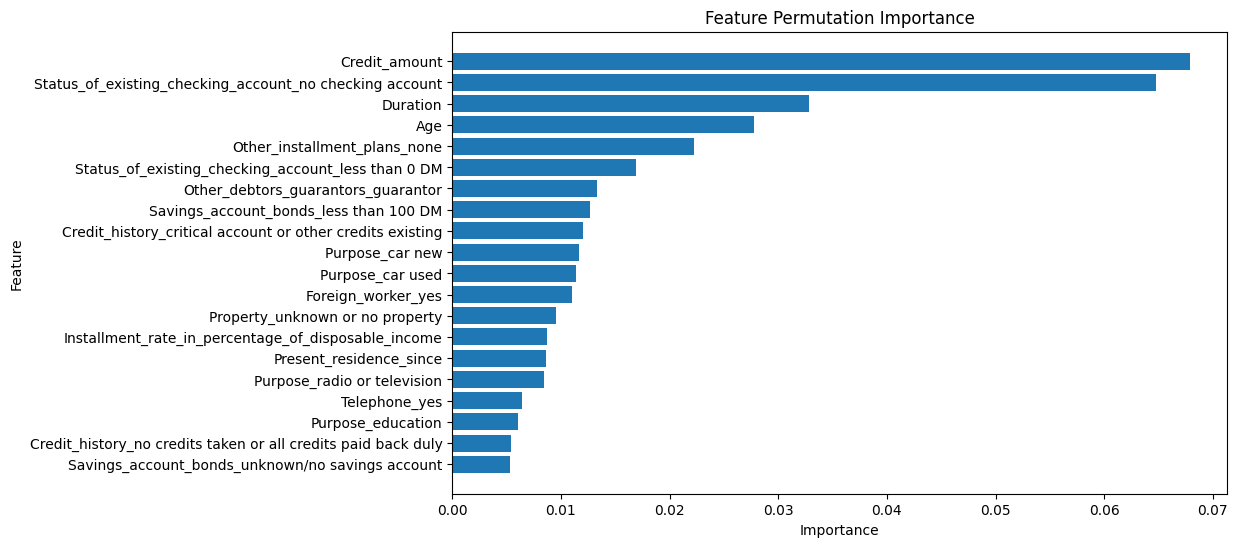

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Credit_amount']

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Credit_amount', 'Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Credit_amount', 'Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Credit_amount', 'Status_of_existing_checking_account', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_plans_stores']
Original 

In [ ]:
xgb_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41   96   44  19      48.24   68.33        68.57      68.5     56.55   
1   41  104   36  19      53.25   68.33        74.29      72.5     59.85   
2   44   87   53  16      45.36   73.33        62.14      65.5     56.05   
3   47   69   71  13      39.83   78.33        49.29      58.0     52.81   
4   47   67   73  13      39.17   78.33        47.86      57.0     52.22   
5   46   73   67  14      40.71   76.67        52.14      59.5     53.18   
6   47   72   68  13      40.87   78.33        51.43      59.5     53.71   
7   50   59   81  10      38.17   83.33        42.14      54.5     52.36   
8   53   38  102   7      34.19   88.33        27.14      45.5     49.30   
9   51   34  106   9      32.48   85.00        24.29      42.5     47.00   
10  53   32  108   7      32.92   88.33        22.86      42.5     47.96   
11  56   22  118   4      32.18   93.33        15.71      39.0     47.86   
12  57   13  127   3      30.98   95.00         9.29      35.0     46.72   
13  54   14  126   6      30.00   90.00        10.00      34.0     45.00   
14  56    5  135   4      29.32   93.33         3.57      30.5     44.62   
15  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               68.45                 0   
1               71.31                 1   
2               67.74                 2   
3               63.81                 3   
4               63.10                 4   
5               64.40                 5   
6               64.88                 6   
7               62.74                 7   
8               57.74                 8   
9               54.64                 9   
10              55.60                10   
11              54.52                11   
12              52.14                12   
13              50.00                13   
14              48.45                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                           ['Credit_amount'] imputed  
2   ['Credit_amount', 'Status_of_existing_checking...  
3   ['Credit_amount', 'Status_of_existing_checking...  
4   ['Credit_amount', 'Status_of_existing_checking...  
5   ['Credit_amount', 'Status_of_existing_checking...  
6   ['Credit_amount', 'Status_of_existing_checking...  
7   ['Credit_amount', 'Status_of_existing_checking...  
8   ['Credit_amount', 'Status_of_existing_checking...  
9   ['Credit_amount', 'Status_of_existing_checking...  
10  ['Credit_amount', 'Status_of_existing_checking...  
11  ['Credit_amount', 'Status_of_existing_checking...  
12  ['Credit_amount', 'Status_of_existing_checking...  
13  ['Credit_amount', 'Status_of_existing_checking...  
14  ['Credit_amount', 'Status_of_existing_checking...  
15  ['Credit_amount', 'Status_of_existing_checking...  
16  ['Credit_amount', 'Status_of_existing_checking...  
17  ['Credit_amount', 'Status_of_existing_checking...  
18  ['Credit_amount', 'Status_of_existing_checking...  
19  ['Credit_amount', 'Status_of_existing_checking...  
20  ['Credit_amount', 'Status_of_existing_checking...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:28:41.230943

--- NEW ITERATION ---
Removing feature:  Credit_amount
Nr. columns with nan:  1
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly', 'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_

In [ ]:
xgb_perf_mf

tp   tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41   96  44  19      48.24   68.33        68.57      68.5     56.55   
1   38   97  43  22      46.91   63.33        69.29      67.5     53.90   
2   36   83  57  24      38.71   60.00        59.29      59.5     47.06   
3   37   89  51  23      42.05   61.67        63.57      63.0     50.00   
4   38   88  52  22      42.22   63.33        62.86      63.0     50.67   
5   37   95  45  23      45.12   61.67        67.86      66.0     52.11   
6   38   95  45  22      45.78   63.33        67.86      66.5     53.15   
7   46   76  64  14      41.82   76.67        54.29      61.0     54.12   
8   49   57  83  11      37.12   81.67        40.71      53.0     51.04   
9   49   54  86  11      36.30   81.67        38.57      51.5     50.26   
10  51   53  87   9      36.96   85.00        37.86      52.0     51.52   
11  45   51  89  15      33.58   75.00        36.43      48.0     46.39   
12  40   50  90  20      30.77   66.67        35.71      45.0     42.11   
13  41   50  90  19      31.30   68.33        35.71      45.5     42.93   
14  41   53  87  19      32.03   68.33        37.86      47.0     43.62   
15  41   50  90  19      31.30   68.33        35.71      45.5     42.93   
16  42   53  87  18      32.56   70.00        37.86      47.5     44.44   
17  15   80  60  45      20.00   25.00        57.14      47.5     22.22   
18  10  123  17  50      37.04   16.67        87.86      66.5     22.99   
19   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
20   0  140   0  60       0.00    0.00       100.00      70.0      0.00   

    balanced_accuracy  num_feat_missing  \
0               68.45                 0   
1               66.31                 1   
2               59.64                 2   
3               62.62                 3   
4               63.10                 4   
5               64.76                 5   
6               65.60                 6   
7               65.48                 7   
8               61.19                 8   
9               60.12                 9   
10              61.43                10   
11              55.71                11   
12              51.19                12   
13              52.02                13   
14              53.10                14   
15              52.02                15   
16              53.93                16   
17              41.07                17   
18              52.26                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                           ['Credit_amount'] imputed  
2   ['Credit_amount', 'Status_of_existing_checking...  
3   ['Credit_amount', 'Status_of_existing_checking...  
4   ['Credit_amount', 'Status_of_existing_checking...  
5   ['Credit_amount', 'Status_of_existing_checking...  
6   ['Credit_amount', 'Status_of_existing_checking...  
7   ['Credit_amount', 'Status_of_existing_checking...  
8   ['Credit_amount', 'Status_of_existing_checking...  
9   ['Credit_amount', 'Status_of_existing_checking...  
10  ['Credit_amount', 'Status_of_existing_checking...  
11  ['Credit_amount', 'Status_of_existing_checking...  
12  ['Credit_amount', 'Status_of_existing_checking...  
13  ['Credit_amount', 'Status_of_existing_checking...  
14  ['Credit_amount', 'Status_of_existing_checking...  
15  ['Credit_amount', 'Status_of_existing_checking...  
16  ['Credit_amount', 'Status_of_existing_checking...  
17  ['Credit_amount', 'Status_of_existing_checking...  
18  ['Credit_amount', 'Status_of_existing_checking...  
19  ['Credit_amount', 'Status_of_existing_checking...  
20  ['Credit_amount', 'Status_of_existing_checking...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.05, 0.01, 2],
      'min_samples_leaf': [0.05, 0.01, 1]
  }
else:
  # best model
  et_param_grid = {
    'n_estimators': [500],
    'max_depth': [2],
    'max_features':['sqrt'],
    'min_samples_split': [0.05],
    'min_samples_leaf': [0.01],
}

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:31:26.851055

Nested Cross-validation Results:
Individual scores: [0.50847458 0.58064516 0.64       0.6504065  0.63865546]
Average nested CV score: 0.604 (+/- 0.107)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.05, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.604

Train score: 0.617
Test score: 0.604
Train-test score difference: 0.014
2025-01-19 00:31:34.755943

Execution time: 0.13 minutes


```
Starting hyperparameter tuning at: 2025-01-15 04:44:09.957706

Nested Cross-validation Results:
Individual scores: [0.47272727 0.55045872 0.61290323 0.56716418 0.59649123]
Average nested CV score: 0.560 (+/- 0.098)

Fitting final model on entire dataset...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.05, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.604

Train score: 0.617
Test score: 0.604
Train-test score difference: 0.014
2025-01-15 05:10:54.764291

Execution time: 26.75 minutes
```




In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.086047  0.014866
39                               Property_real estate    0.015180  0.003095
10  Status_of_existing_checking_account_less than ...    0.006185  0.003612
28   Savings_account_bonds_unknown/no savings account    0.006151  0.003464
12  Credit_history_critical account or other credi...    0.005607  0.010350
27             Savings_account_bonds_less than 100 DM    0.003952  0.007620
41                       Other_installment_plans_none    0.003559  0.004218
8                                  Foreign_worker_yes    0.003259  0.001251
25          Savings_account_bonds_from 500 to 1000 DM    0.003138  0.002343
4                                                 Age    0.002731  0.000913
22                        Purpose_radio or television    0.002063  0.002286
3                             Present_residence_since    0.001819  0.000910
42                     Other_installment_plans_stores    0.001365  0.001114
6   Number_of_people_being_liable_to_provide_maint...    0.000910  0.001114
2   Installment_rate_in_percentage_of_disposable_i...    0.000910  0.001114
26  Savings_account_bonds_greater or equal to 1000 DM    0.000848  0.001045
37                      Other_debtors_guarantors_none    0.000455  0.000910
47                           Job_unskilled - resident    0.000455  0.000910
0                                            Duration    0.000042  0.005002
17                                   Purpose_car used   -0.000277  0.001595
13     Credit_history_delay in paying off in the past   -0.000395  0.000484
33  Personal_status_and_sex_male divorced or separ...   -0.000453  0.000907
32                Present_employment_since_unemployed   -0.000453  0.000907
40                    Property_unknown or no property   -0.000490  0.003804
1                                       Credit_amount   -0.000649  0.002488
36                 Other_debtors_guarantors_guarantor   -0.000732  0.001249
9   Status_of_existing_checking_account_greater or...   -0.001359  0.001816
16                                    Purpose_car new   -0.001440  0.001981
43                                        Housing_own   -0.001524  0.002048
35                Personal_status_and_sex_male single   -0.001812  0.001694
15  Credit_history_no credits taken or all credits...   -0.002013  0.001563
31          Present_employment_since_less than 1 year   -0.004553  0.002048

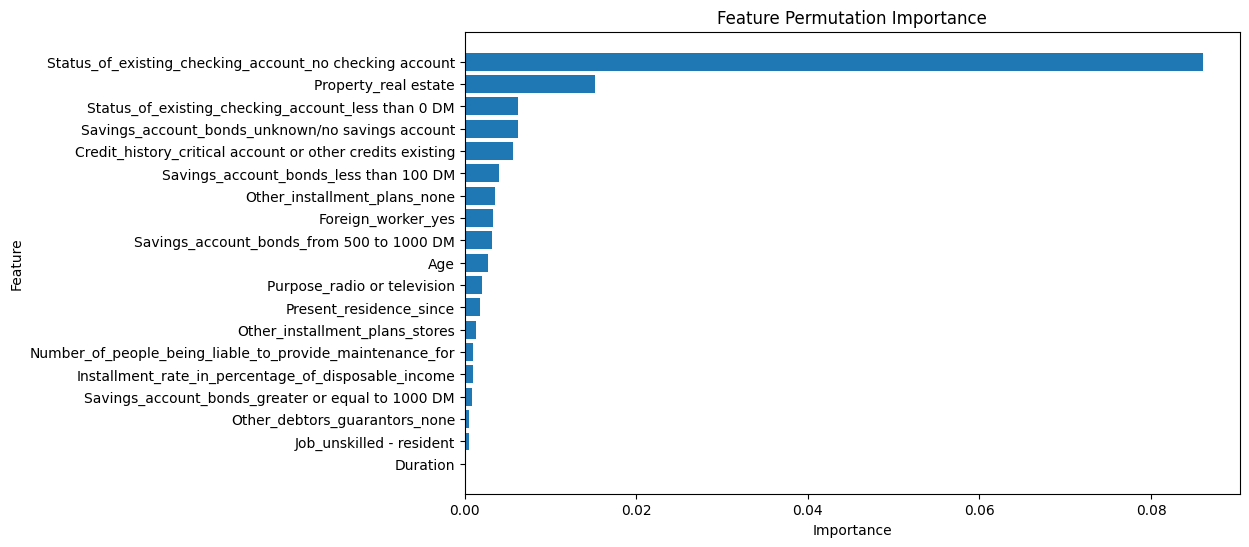

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Property_real estate
Removing related features:  ['Property_car or other', 'Property_real estate', 'Property_unknown or no property']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Property']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_unknown/no savings account
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Origina

In [ ]:
et_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  91   49  11      50.00   81.67        65.00      70.0     62.03   
1   51  62   78   9      39.53   85.00        44.29      56.5     53.97   
2   52  56   84   8      38.24   86.67        40.00      54.0     53.06   
3   59  33  107   1      35.54   98.33        23.57      46.0     52.21   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.33                 0   
1               64.64                 1   
2               63.33                 2   
3               60.95                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:31:41.257574

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
et_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  91   49  11      50.00   81.67        65.00      70.0     62.03   
1   42  76   64  18      39.62   70.00        54.29      59.0     50.60   
2   44  69   71  16      38.26   73.33        49.29      56.5     50.29   
3   52  38  102   8      33.77   86.67        27.14      45.0     48.60   
4   51  20  120   9      29.82   85.00        14.29      35.5     44.16   
5   52  21  119   8      30.41   86.67        15.00      36.5     45.02   
6   52  22  118   8      30.59   86.67        15.71      37.0     45.22   
7   52  22  118   8      30.59   86.67        15.71      37.0     45.22   
8   48  27  113  12      29.81   80.00        19.29      37.5     43.44   
9   48  27  113  12      29.81   80.00        19.29      37.5     43.44   
10  48  27  113  12      29.81   80.00        19.29      37.5     43.44   
11  50  28  112  10      30.86   83.33        20.00      39.0     45.05   
12  50  32  108  10      31.65   83.33        22.86      41.0     45.87   
13  52  34  106   8      32.91   86.67        24.29      43.0     47.71   
14  52  34  106   8      32.91   86.67        24.29      43.0     47.71   
15  51  36  104   9      32.90   85.00        25.71      43.5     47.44   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.33                 0   
1               62.14                 1   
2               61.31                 2   
3               56.90                 3   
4               49.64                 4   
5               50.83                 5   
6               51.19                 6   
7               51.19                 7   
8               49.64                 8   
9               49.64                 9   
10              49.64                10   
11              51.67                11   
12              53.10                12   
13              55.48                13   
14              55.48                14   
15              55.36                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, german_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = german_scaler)

In [ ]:
german_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
german_imputation_scaled_values_dict

{'Duration': 0.20588235294117646,
 'Credit_amount': 0.11395400022009465,
 'Installment_rate_in_percentage_of_disposable_income': 0.6666666666666667,
 'Present_residence_since': 0.6666666666666667,
 'Age': 0.25000000000000006,
 'Number_of_existing_credits_at_this_bank': 0.0,
 'Number_of_people_being_liable_to_provide_maintenance_for': 0.0,
 'Telephone_yes': 0.0,
 'Foreign_worker_yes': 1.0,
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 0.0,
 'Status_of_existing_checking_account_less than 0 DM': 0.0,
 'Status_of_existing_checking_account_no checking account': 0.0,
 'Credit_history_critical account or other credits existing': 0.0,
 'Credit_history_delay in paying off in the past': 0.0,
 'Credit_history_existing credits paid back duly till now': 1.0,
 'Credit_history_no credits taken or all credits paid back duly': 0.0,
 'Purpose_car new': 0.0,
 'Purpose_car used': 0.0,
 'Purpose_domestic appliances': 0.0,
 'Purpose_education': 0.0,
 'Purpose_furni

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 3, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [0.1],
    'kernel': ['poly'],
    'gamma': ['scale'],
    'degree': [2]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 5, 5, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:05:53.827964

Nested Cross-validation Results:
Individual scores: [0.50819672 0.625      0.63076923 0.640625   0.63934426]
Average nested CV score: 0.609 (+/- 0.101)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.609

Train score: 0.634
Test score: 0.609
Train-test score difference: 0.026
2025-01-19 00:05:56.843278

Execution time: 0.05 minutes


```
Starting hyperparameter tuning at: 2025-01-15 05:10:54.801642

Nested Cross-validation Results:
Individual scores: [0.4957265  0.45283019 0.6        0.63076923 0.64220183]
Average nested CV score: 0.564 (+/- 0.152)

Fitting final model on entire dataset...
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.609

Train score: 0.634
Test score: 0.609
Train-test score difference: 0.026
2025-01-15 05:12:25.788250

Execution time: 1.52 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.073752  0.005077
41                       Other_installment_plans_none    0.019071  0.002420
22                        Purpose_radio or television    0.012604  0.004839
0                                            Duration    0.009185  0.002831
27             Savings_account_bonds_less than 100 DM    0.007489  0.003348
10  Status_of_existing_checking_account_less than ...    0.006744  0.008113
39                               Property_real estate    0.006568  0.004669
14  Credit_history_existing credits paid back duly...    0.005530  0.002802
38                              Property_car or other    0.004915  0.002477
28   Savings_account_bonds_unknown/no savings account    0.004911  0.005210
42                     Other_installment_plans_stores    0.004049  0.002057
29         Present_employment_since_from 4 to 7 years    0.004040  0.003467
45                   Job_skilled employee or official    0.004014  0.002447
35                Personal_status_and_sex_male single    0.003813  0.003739
26  Savings_account_bonds_greater or equal to 1000 DM    0.003748  0.001351
12  Credit_history_critical account or other credi...    0.003222  0.001622
1                                       Credit_amount    0.002885  0.001743
3                             Present_residence_since    0.002685  0.004149
31          Present_employment_since_less than 1 year    0.002558  0.002267
7                                       Telephone_yes    0.002095  0.002430
36                 Other_debtors_guarantors_guarantor    0.002057  0.001705
32                Present_employment_since_unemployed    0.001892  0.001386
30  Present_employment_since_greater or equal to 7...    0.001829  0.000500
33  Personal_status_and_sex_male divorced or separ...    0.001693  0.001258
17                                   Purpose_car used    0.001663  0.003514
8                                  Foreign_worker_yes    0.001397  0.000488
9   Status_of_existing_checking_account_greater or...    0.001395  0.001015
37                      Other_debtors_guarantors_none    0.001197  0.000746
40                    Property_unknown or no property    0.001191  0.002585
2   Installment_rate_in_percentage_of_disposable_i...    0.001183  0.004043
4                                                 Age    0.001089  0.002608
6   Number_of_people_being_liable_to_provide_maint...    0.000961  0.001630
34    Personal_status_and_sex_male married or widowed    0.000863  0.001057
13     Credit_history_delay in paying off in the past    0.000599  0.000489
44                                       Housing_rent    0.000399  0.000489
23                                    Purpose_repairs    0.000199  0.000748
15  Credit_history_no credits taken or all credits...   -0.000077  0.001040
47                           Job_unskilled - resident   -0.000086  0.002943
19                                  Purpose_education   -0.000401  0.000800
20                     Purpose_furniture or equipment   -0.000401  0.000800
16                                    Purpose_car new   -0.000461  0.002452
25          Savings_account_bonds_from 500 to 1000 DM   -0.001121  0.000681
43                                        Housing_own   -0.005860  0.002490

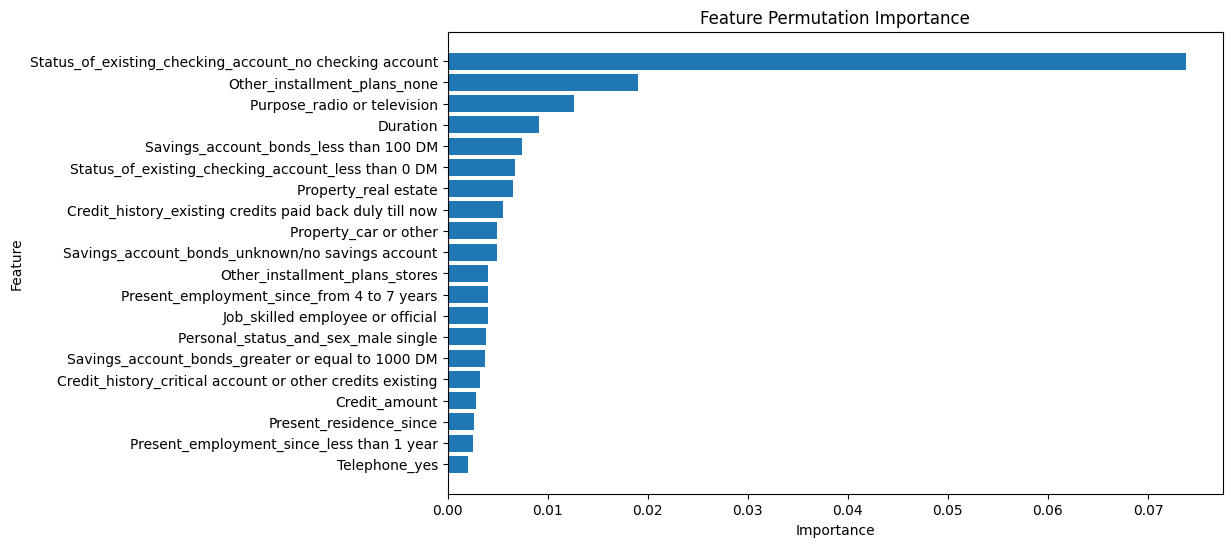

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_plans_stores']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Other_installment_plans']

--- NEW ITERATION ---
Removing feature:  Purpose_radio or television
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed s

In [ ]:
svm_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   48  87   53  12      47.52   80.00        62.14      67.5     59.63   
1   56  49   91   4      38.10   93.33        35.00      52.5     54.11   
2   54  55   85   6      38.85   90.00        39.29      54.5     54.27   
3   55  44   96   5      36.42   91.67        31.43      49.5     52.13   
4   54  44   96   6      36.00   90.00        31.43      49.0     51.43   
5   55  22  118   5      31.79   91.67        15.71      38.5     47.21   
6   59  23  117   1      33.52   98.33        16.43      41.0     50.00   
7   60   3  137   0      30.46  100.00         2.14      31.5     46.69   
8   60   3  137   0      30.46  100.00         2.14      31.5     46.69   
9   60   1  139   0      30.15  100.00         0.71      30.5     46.33   
10  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
11  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
12  60   2  138   0      30.30  100.00         1.43      31.0     46.51   
13  60   2  138   0      30.30  100.00         1.43      31.0     46.51   
14  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               71.07                 0   
1               64.17                 1   
2               64.64                 2   
3               61.55                 3   
4               60.71                 4   
5               53.69                 5   
6               57.38                 6   
7               51.07                 7   
8               51.07                 8   
9               50.36                 9   
10              50.36                10   
11              50.36                11   
12              50.71                12   
13              50.71                13   
14              50.36                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:34:31.327176

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
svm_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   48  87   53  12      47.52   80.00        62.14      67.5     59.63   
1   44  71   69  16      38.94   73.33        50.71      57.5     50.87   
2   43  73   67  17      39.09   71.67        52.14      58.0     50.59   
3   43  67   73  17      37.07   71.67        47.86      55.0     48.86   
4   43  67   73  17      37.07   71.67        47.86      55.0     48.86   
5   50  37  103  10      32.68   83.33        26.43      43.5     46.95   
6   52  32  108   8      32.50   86.67        22.86      42.0     47.27   
7   48  24  116  12      29.27   80.00        17.14      36.0     42.86   
8   55   5  135   5      28.95   91.67         3.57      30.0     44.00   
9   59   7  133   1      30.73   98.33         5.00      33.0     46.83   
10  60   4  136   0      30.61  100.00         2.86      32.0     46.88   
11  60   4  136   0      30.61  100.00         2.86      32.0     46.88   
12  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
13  58   3  137   2      29.74   96.67         2.14      30.5     45.49   
14  58   4  136   2      29.90   96.67         2.86      31.0     45.67   
15  59   1  139   1      29.80   98.33         0.71      30.0     45.74   
16  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               71.07                 0   
1               62.02                 1   
2               61.90                 2   
3               59.76                 3   
4               59.76                 4   
5               54.88                 5   
6               54.76                 6   
7               48.57                 7   
8               47.62                 8   
9               51.67                 9   
10              51.43                10   
11              51.43                11   
12              50.36                12   
13              49.40                13   
14              49.76                14   
15              49.52                15   
16              50.36                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicollinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_german_dist_corr = german_dist_corr[present_features]
filtered_german_dist_corr = filtered_german_dist_corr[filtered_german_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_german_dist_corr, 'Target', 0.8)

appended feature:  Status_of_existing_checking_account_no checking account
appended feature:  Status_of_existing_checking_account_less than 0 DM
appended feature:  Duration
appended feature:  Credit_amount
appended feature:  Credit_history_critical account or other credits existing
appended feature:  Savings_account_bonds_less than 100 DM
appended feature:  Other_installment_plans_none
appended feature:  Property_unknown or no property
appended feature:  Property_real estate
appended feature:  Savings_account_bonds_unknown/no savings account
appended feature:  Credit_history_no credits taken or all credits paid back duly
appended feature:  Purpose_radio or television
appended feature:  Present_employment_since_less than 1 year
appended feature:  Housing_own
appended feature:  Foreign_worker_yes
appended feature:  Purpose_car new
appended feature:  Age
appended feature:  Purpose_car used
appended feature:  Personal_status_and_sex_male divorced or separated
appended feature:  Savings_acc

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  48


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm for optimization
  }
else:
  # best model
  lr_param_grid = {
    'C': [1.0],
    'penalty': ['l1'],
    'solver': ['liblinear']
}

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 5, 5, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:06:43.536570

Nested Cross-validation Results:
Individual scores: [0.5840708  0.5862069  0.60869565 0.67272727 0.66666667]
Average nested CV score: 0.624 (+/- 0.077)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.624

Train score: 0.659
Test score: 0.624
Train-test score difference: 0.035
2025-01-19 00:06:43.819214

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 05:12:26.210003

Nested Cross-validation Results:
Individual scores: [0.50434783 0.54867257 0.60869565 0.62608696 0.66666667]
Average nested CV score: 0.591 (+/- 0.115)

Fitting final model on entire dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.624

Train score: 0.659
Test score: 0.624
Train-test score difference: 0.035
2025-01-15 05:12:31.365592

Execution time: 0.09 minutes
```




In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0   Status_of_existing_checking_account_no checkin...    0.070301  0.010814
4   Credit_history_critical account or other credi...    0.028787  0.006760
3                                       Credit_amount    0.025103  0.009682
6                        Other_installment_plans_none    0.024606  0.006759
16                                                Age    0.018189  0.005686
26  Installment_rate_in_percentage_of_disposable_i...    0.016889  0.009095
23                 Other_debtors_guarantors_guarantor    0.015495  0.004324
32  Credit_history_existing credits paid back duly...    0.014466  0.003662
9    Savings_account_bonds_unknown/no savings account    0.009969  0.006094
46     Credit_history_delay in paying off in the past    0.009709  0.005004
14                                 Foreign_worker_yes    0.009468  0.001468
22         Present_employment_since_from 4 to 7 years    0.008876  0.004893
2                                            Duration    0.008684  0.012763
25                Personal_status_and_sex_male single    0.007625  0.005085
5              Savings_account_bonds_less than 100 DM    0.007237  0.004880
15                                    Purpose_car new    0.006310  0.003995
19  Savings_account_bonds_greater or equal to 1000 DM    0.005508  0.002750
29                                    Purpose_repairs    0.005250  0.001528
17                                   Purpose_car used    0.005072  0.003381
28                           Job_unskilled - resident    0.004635  0.005504
18  Personal_status_and_sex_male divorced or separ...    0.004609  0.001259
1   Status_of_existing_checking_account_less than ...    0.004354  0.004533
38                                     Purpose_others    0.002307  0.002926
36    Personal_status_and_sex_male married or widowed    0.002062  0.002206
12          Present_employment_since_less than 1 year    0.001819  0.001726
8                                Property_real estate    0.000470  0.006923
20          Savings_account_bonds_from 500 to 1000 DM    0.000463  0.000926
31  Status_of_existing_checking_account_greater or...    0.000443  0.002360
45  Number_of_people_being_liable_to_provide_maint...    0.000255  0.002658
44                      Other_debtors_guarantors_none    0.000230  0.003880
24                Present_employment_since_unemployed   -0.000028  0.001253
11                        Purpose_radio or television   -0.000433  0.002589
27                                  Purpose_education   -0.000470  0.002770
41                   Job_skilled employee or official   -0.001379  0.002219
40                                      Telephone_yes   -0.001381  0.005494
13                                        Housing_own   -0.002289  0.003831
7                     Property_unknown or no property   -0.002796  0.002555
35            Number_of_existing_credits_at_this_bank   -0.004346  0.002940

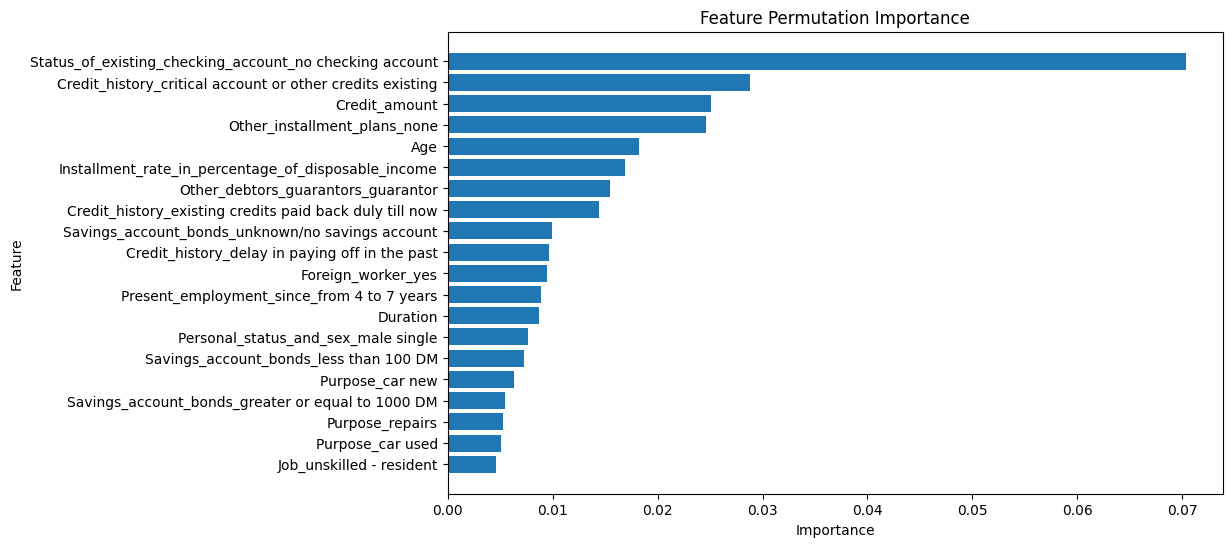

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_history_critical account or other credits existing
Removing related features:  ['Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_history']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_history', 'Cr

In [ ]:
lr_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   44  98   42  16      51.16   73.33        70.00      71.0     60.27   
1   49  75   65  11      42.98   81.67        53.57      62.0     56.32   
2   50  66   74  10      40.32   83.33        47.14      58.0     54.35   
3   49  70   70  11      41.18   81.67        50.00      59.5     54.75   
4   45  81   59  15      43.27   75.00        57.86      63.0     54.88   
5   44  81   59  16      42.72   73.33        57.86      62.5     53.99   
6   45  80   60  15      42.86   75.00        57.14      62.5     54.55   
7   46  80   60  14      43.40   76.67        57.14      63.0     55.42   
8   49  59   81  11      37.69   81.67        42.14      54.0     51.58   
9   51  55   85   9      37.50   85.00        39.29      53.0     52.04   
10  52  47   93   8      35.86   86.67        33.57      49.5     50.73   
11  51  46   94   9      35.17   85.00        32.86      48.5     49.76   
12  44  61   79  16      35.77   73.33        43.57      52.5     48.09   
13  42  66   74  18      36.21   70.00        47.14      54.0     47.73   
14  42  67   73  18      36.52   70.00        47.86      54.5     48.00   
15  37  59   81  23      31.36   61.67        42.14      48.0     41.57   
16  37  63   77  23      32.46   61.67        45.00      50.0     42.53   
17  37  63   77  23      32.46   61.67        45.00      50.0     42.53   
18  37  64   76  23      32.74   61.67        45.71      50.5     42.77   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               71.67                 0   
1               67.62                 1   
2               65.24                 2   
3               65.83                 3   
4               66.43                 4   
5               65.60                 5   
6               66.07                 6   
7               66.90                 7   
8               61.90                 8   
9               62.14                 9   
10              60.12                10   
11              58.93                11   
12              58.45                12   
13              58.57                13   
14              58.93                14   
15              51.90                15   
16              53.33                16   
17              53.33                17   
18              53.69                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
lr_X_train.columns

Index(['Status_of_existing_checking_account_no checking account',
       'Status_of_existing_checking_account_less than 0 DM', 'Duration',
       'Credit_amount',
       'Credit_history_critical account or other credits existing',
       'Savings_account_bonds_less than 100 DM',
       'Other_installment_plans_none', 'Property_unknown or no property',
       'Property_real estate',
       'Savings_account_bonds_unknown/no savings account',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_radio or television',
       'Present_employment_since_less than 1 year', 'Housing_own',
       'Foreign_worker_yes', 'Purpose_car new', 'Age', 'Purpose_car used',
       'Personal_status_and_sex_male divorced or separated',
       'Savings_account_bonds_greater or equal to 1000 DM',
       'Savings_account_bonds_from 500 to 1000 DM',
       'Other_installment_plans_stores',
       'Present_employment_since_from 4 to 7 years',
       'Other_debtors_guarantors_guar

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_german_cat_vars = [col for col in lr_X_train.columns if col in german_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=lr_german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:37:20.909541

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Age', 'Installment_rate_in_percentage_of_disposable_income', 'Number_of_existing_credits_at_this_bank', 'Present_residence_since']
Categorical columns:  ['Status_of_existing_checking_account_no checking account', 'Status_of_existing_checking_account_less than 0 DM', 'Credit_history_critical account or other credits existing', 'Savings_account_bonds_less than 100 DM', 'Other_installment_plans_none', 'Property_unknown or no property', 'Property_real estate', 'Savings_account_bonds_unknown/no savings account', 'Credit_history_no credits taken or all credits paid bac

In [ ]:
lr_perf_mf

tp   tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   44   98  42  16      51.16   73.33        70.00      71.0     60.27   
1   36  105  35  24      50.70   60.00        75.00      70.5     54.96   
2   34   97  43  26      44.16   56.67        69.29      65.5     49.64   
3   33   94  46  27      41.77   55.00        67.14      63.5     47.48   
4   30   97  43  30      41.10   50.00        69.29      63.5     45.11   
5   29  102  38  31      43.28   48.33        72.86      65.5     45.67   
6   30  105  35  30      46.15   50.00        75.00      67.5     48.00   
7   30  105  35  30      46.15   50.00        75.00      67.5     48.00   
8   37   92  48  23      43.53   61.67        65.71      64.5     51.03   
9   39   91  49  21      44.32   65.00        65.00      65.0     52.70   
10  34   83  57  26      37.36   56.67        59.29      58.5     45.03   
11  31   87  53  29      36.90   51.67        62.14      59.0     43.06   
12  27   92  48  33      36.00   45.00        65.71      59.5     40.00   
13  25   88  52  35      32.47   41.67        62.86      56.5     36.50   
14  28   95  45  32      38.36   46.67        67.86      61.5     42.11   
15  25  106  34  35      42.37   41.67        75.71      65.5     42.02   
16  27  105  35  33      43.55   45.00        75.00      66.0     44.26   
17  25  115  25  35      50.00   41.67        82.14      70.0     45.45   
18   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
19   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
20   0  140   0  60       0.00    0.00       100.00      70.0      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.67                 0   
1               67.50                 1   
2               62.98                 2   
3               61.07                 3   
4               59.64                 4   
5               60.60                 5   
6               62.50                 6   
7               62.50                 7   
8               63.69                 8   
9               65.00                 9   
10              57.98                10   
11              56.90                11   
12              55.36                12   
13              52.26                13   
14              57.26                14   
15              58.69                15   
16              60.00                16   
17              61.90                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 0.005, 1]    # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [3],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.01],
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(dt2_classifier, dt2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train)

Starting hyperparameter tuning at: 2025-01-19 00:40:08.600527

Nested Cross-validation Results:
Individual scores: [0.70386905 0.68303571 0.68005952 0.6235119  0.70386905]
Average nested CV score: 0.679 (+/- 0.059)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.679

Train score: 0.722
Test score: 0.679
Train-test score difference: 0.043
2025-01-19 00:40:11.975707

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-15 05:12:31.372755

Nested Cross-validation Results:
Individual scores: [0.57738095 0.66517857 0.64880952 0.65625    0.65625   ]
Average nested CV score: 0.641 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.679

Train score: 0.722
Test score: 0.679
Train-test score difference: 0.043
2025-01-15 05:12:51.052939

Execution time: 0.33 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.172679  0.010864
41                       Other_installment_plans_none    0.038036  0.004108
36                 Other_debtors_guarantors_guarantor    0.019405  0.002301
4                                                 Age    0.007738  0.000652
0                                            Duration    0.006488  0.003832

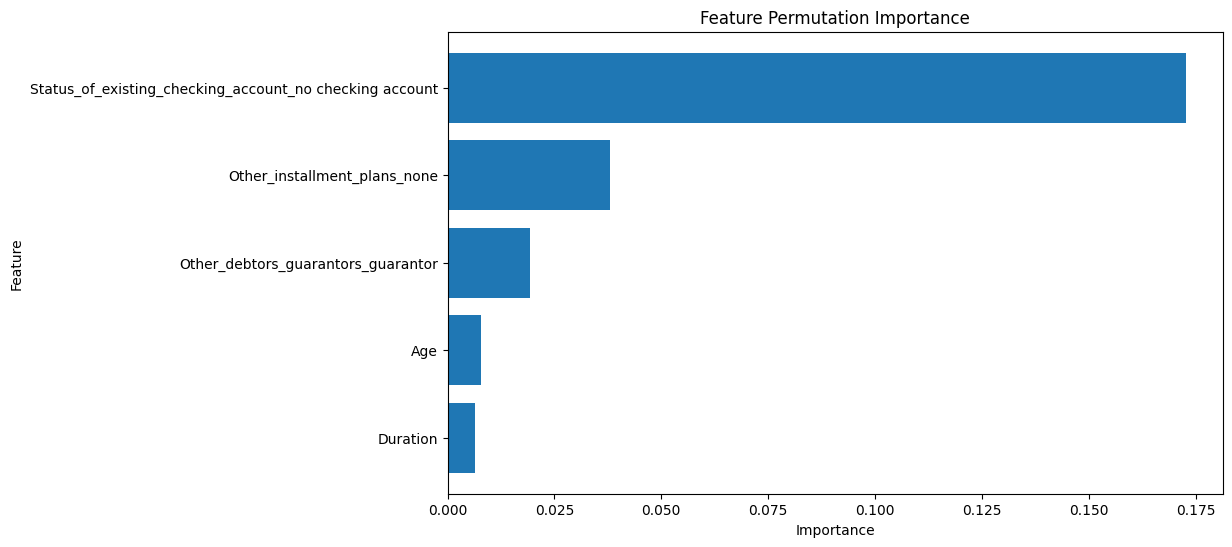

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_plans_stores']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Other_installment_plans']

--- NEW ITERATION ---
Removing feature:  Other_debtors_guarantors_guarantor
Removing related features:  ['Other_debtors_guarantors_guarantor', 'Other_debtors_guarantors_none']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Other_installment_plans', 'Other_debtors_guarantors']

--- NEW ITERATION ---
Removing fe

In [ ]:
dt2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   51  63   77   9      39.84   85.00        45.00      57.0     54.26   
1   59   3  137   1      30.10   98.33         2.14      31.0     46.09   
2   59   3  137   1      30.10   98.33         2.14      31.0     46.09   
3   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               65.00                 0   
1               50.24                 1   
2               50.24                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:40:12.864266

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
dt2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   51  63   77   9      39.84   85.00        45.00      57.0     54.26   
1   45  50   90  15      33.33   75.00        35.71      47.5     46.15   
2   45  55   85  15      34.62   75.00        39.29      50.0     47.37   
3   46  51   89  14      34.07   76.67        36.43      48.5     47.18   
4   46  52   88  14      34.33   76.67        37.14      49.0     47.42   
5   46  51   89  14      34.07   76.67        36.43      48.5     47.18   
6   53  31  109   7      32.72   88.33        22.14      42.0     47.75   
7   54  33  107   6      33.54   90.00        23.57      43.5     48.87   
8   55  36  104   5      34.59   91.67        25.71      45.5     50.23   
9   57  30  110   3      34.13   95.00        21.43      43.5     50.22   
10  57  25  115   3      33.14   95.00        17.86      41.0     49.14   
11  54  26  114   6      32.14   90.00        18.57      40.0     47.37   
12  56  30  110   4      33.73   93.33        21.43      43.0     49.56   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  58   5  135   2      30.05   96.67         3.57      31.5     45.85   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               65.00                 0   
1               55.36                 1   
2               57.14                 2   
3               56.55                 3   
4               56.90                 4   
5               56.55                 5   
6               55.24                 6   
7               56.79                 7   
8               58.69                 8   
9               58.21                 9   
10              56.43                10   
11              54.29                11   
12              57.38                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.12                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 2],
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 1]
  }
else:
  rf2_param_grid = {
    'n_estimators': [300],
    'max_features': ['sqrt'],
    'max_depth': [3],
    'min_samples_leaf': [0.01],
    'min_samples_split': [0.1],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:42:59.453122

Nested Cross-validation Results:
Individual scores: [0.66517857 0.72767857 0.75446429 0.76339286 0.73214286]
Average nested CV score: 0.729 (+/- 0.069)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.1, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.729

Train score: 0.762
Test score: 0.729
Train-test score difference: 0.034
2025-01-19 00:43:05.881629

Execution time: 0.11 minutes


```
Starting hyperparameter tuning at: 2025-01-15 05:12:51.061738

Nested Cross-validation Results:
Individual scores: [0.63690476 0.71130952 0.73065476 0.70833333 0.73214286]
Average nested CV score: 0.704 (+/- 0.070)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.1, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.729

Train score: 0.762
Test score: 0.729
Train-test score difference: 0.034
2025-01-15 05:50:05.731756

Execution time: 37.24 minutes
```




In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11  Status_of_existing_checking_account_no checkin...  7.720238e-02  0.012723
0                                            Duration  2.559524e-02  0.008758
1                                       Credit_amount  2.267857e-02  0.004946
28   Savings_account_bonds_unknown/no savings account  1.339286e-02  0.004568
41                       Other_installment_plans_none  1.291667e-02  0.002200
4                                                 Age  1.095238e-02  0.004012
27             Savings_account_bonds_less than 100 DM  1.029762e-02  0.003739
39                               Property_real estate  9.166667e-03  0.004082
22                        Purpose_radio or television  8.035714e-03  0.000903
40                    Property_unknown or no property  5.476190e-03  0.003422
10  Status_of_existing_checking_account_less than ...  5.059524e-03  0.004502
2   Installment_rate_in_percentage_of_disposable_i...  4.880952e-03  0.002325
12  Credit_history_critical account or other credi...  4.702381e-03  0.005125
3                             Present_residence_since  4.047619e-03  0.002159
29         Present_employment_since_from 4 to 7 years  3.809524e-03  0.002391
36                 Other_debtors_guarantors_guarantor  3.571429e-03  0.001541
31          Present_employment_since_less than 1 year  3.452381e-03  0.001416
26  Savings_account_bonds_greater or equal to 1000 DM  2.857143e-03  0.000934
47                           Job_unskilled - resident  2.738095e-03  0.001886
37                      Other_debtors_guarantors_none  2.678571e-03  0.000820
8                                  Foreign_worker_yes  2.321429e-03  0.001613
34    Personal_status_and_sex_male married or widowed  1.845238e-03  0.001226
32                Present_employment_since_unemployed  1.845238e-03  0.000985
16                                    Purpose_car new  1.785714e-03  0.000565
38                              Property_car or other  1.547619e-03  0.002238
14  Credit_history_existing credits paid back duly...  1.369048e-03  0.001185
44                                       Housing_rent  1.190476e-03  0.000820
17                                   Purpose_car used  1.071429e-03  0.002659
7                                       Telephone_yes  9.523810e-04  0.000663
6   Number_of_people_being_liable_to_provide_maint...  8.333333e-04  0.001021
9   Status_of_existing_checking_account_greater or...  7.142857e-04  0.000357
30  Present_employment_since_greater or equal to 7...  4.166667e-04  0.000833
23                                    Purpose_repairs  3.571429e-04  0.000437
45                   Job_skilled employee or official  1.190476e-04  0.000952
33  Personal_status_and_sex_male divorced or separ...  4.440892e-17  0.001318
13     Credit_history_delay in paying off in the past -1.785714e-04  0.000357
25          Savings_account_bonds_from 500 to 1000 DM -2.380952e-04  0.002331
42                     Other_installment_plans_stores -4.166667e-04  0.000833
35                Personal_status_and_sex_male single -5.357143e-04  0.002376
15  Credit_history_no credits taken or all credits... -1.369048e-03  0.001154
43                                        Housing_own -1.428571e-03  0.002832
5             Number_of_existing_credits_at_this_bank -1.428571e-03  0.001211
20                     Purpose_furniture or equipment -2.261905e-03  0.000357

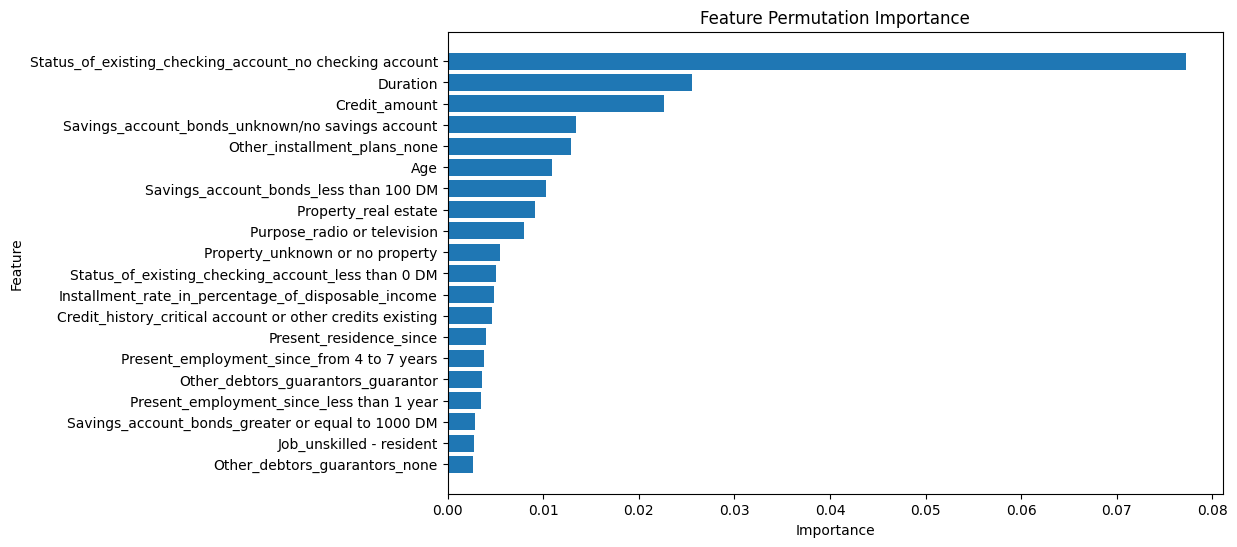

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_unknown/no savings account
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']

In [ ]:
rf2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   47  92   48  13      49.47   78.33        65.71      69.5     60.65   
1   50  61   79  10      38.76   83.33        43.57      55.5     52.91   
2   52  52   88   8      37.14   86.67        37.14      52.0     52.00   
3   50  61   79  10      38.76   83.33        43.57      55.5     52.91   
4   58  36  104   2      35.80   96.67        25.71      47.0     52.25   
5   57  38  102   3      35.85   95.00        27.14      47.5     52.05   
6   57  29  111   3      33.93   95.00        20.71      43.0     50.00   
7   58  25  115   2      33.53   96.67        17.86      41.5     49.79   
8   57  12  128   3      30.81   95.00         8.57      34.5     46.53   
9   57  14  126   3      31.15   95.00        10.00      35.5     46.91   
10  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
11  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.02                 0   
1               63.45                 1   
2               61.90                 2   
3               63.45                 3   
4               61.19                 4   
5               61.07                 5   
6               57.86                 6   
7               57.26                 7   
8               51.79                 8   
9               52.50                 9   
10              50.36                10   
11              50.36                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:43:10.304252

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
rf2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   47  92   48  13      49.47   78.33        65.71      69.5     60.65   
1   42  77   63  18      40.00   70.00        55.00      59.5     50.91   
2   42  73   67  18      38.53   70.00        52.14      57.5     49.70   
3   40  74   66  20      37.74   66.67        52.86      57.0     48.19   
4   52  44   96   8      35.14   86.67        31.43      48.0     50.00   
5   52  45   95   8      35.37   86.67        32.14      48.5     50.24   
6   52  42   98   8      34.67   86.67        30.00      47.0     49.52   
7   50  40  100  10      33.33   83.33        28.57      45.0     47.62   
8   52  38  102   8      33.77   86.67        27.14      45.0     48.60   
9   51  36  104   9      32.90   85.00        25.71      43.5     47.44   
10  48  27  113  12      29.81   80.00        19.29      37.5     43.44   
11  48  26  114  12      29.63   80.00        18.57      37.0     43.24   
12  53   5  135   7      28.19   88.33         3.57      29.0     42.74   
13  52   5  135   8      27.81   86.67         3.57      28.5     42.11   
14  59   4  136   1      30.26   98.33         2.86      31.5     46.27   
15  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.02                 0   
1               62.50                 1   
2               61.07                 2   
3               59.76                 3   
4               59.05                 4   
5               59.40                 5   
6               58.33                 6   
7               55.95                 7   
8               56.90                 8   
9               55.36                 9   
10              49.64                10   
11              49.29                11   
12              45.95                12   
13              45.12                13   
14              50.60                14   
15              50.95                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [40, 8, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'min_child_samples': [8],
    'min_split_gain': [1.0],
    'reg_lambda': [0.0]
}

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid,5, 5, 'balanced_accuracy', X_train,y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:45:56.726735

Nested Cross-validation Results:
Individual scores: [0.6860119  0.69940476 0.71279762 0.72916667 0.78571429]
Average nested CV score: 0.723 (+/- 0.069)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 8, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.723

Train score: 0.827
Test score: 0.723
Train-test score difference: 0.104
2025-01-19 00:45:58.463926

Execution time: 0.03 minutes


```
Starting hyperparameter tuning at: 2025-01-15 05:50:05.740021

Nested Cross-validation Results:
Individual scores: [0.66220238 0.66666667 0.70833333 0.72321429 0.79166667]
Average nested CV score: 0.710 (+/- 0.094)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 8, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.723

Train score: 0.827
Test score: 0.723
Train-test score difference: 0.104
2025-01-15 05:52:50.854699

Execution time: 2.75 minutes
```




In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.084167  0.006303
1                                       Credit_amount    0.054702  0.004711
0                                            Duration    0.024107  0.007772
4                                                 Age    0.019345  0.006602
41                       Other_installment_plans_none    0.017917  0.005867
16                                    Purpose_car new    0.015119  0.003523
12  Credit_history_critical account or other credi...    0.013571  0.002692
8                                  Foreign_worker_yes    0.011548  0.001376
36                 Other_debtors_guarantors_guarantor    0.011131  0.003136
17                                   Purpose_car used    0.010298  0.003663
27             Savings_account_bonds_less than 100 DM    0.009107  0.003291
29         Present_employment_since_from 4 to 7 years    0.007440  0.003404
28   Savings_account_bonds_unknown/no savings account    0.007262  0.002950
10  Status_of_existing_checking_account_less than ...    0.007202  0.002293
2   Installment_rate_in_percentage_of_disposable_i...    0.006905  0.004347
26  Savings_account_bonds_greater or equal to 1000 DM    0.006726  0.003725
19                                  Purpose_education    0.005060  0.001263
40                    Property_unknown or no property    0.003690  0.002041
22                        Purpose_radio or television    0.003155  0.002840
7                                       Telephone_yes    0.002917  0.000546
23                                    Purpose_repairs    0.002619  0.000437
32                Present_employment_since_unemployed    0.001964  0.001041
39                               Property_real estate    0.001667  0.003987
35                Personal_status_and_sex_male single    0.000714  0.000357
15  Credit_history_no credits taken or all credits...    0.000655  0.001136
43                                        Housing_own    0.000536  0.000714
3                             Present_residence_since    0.000179  0.001312
33  Personal_status_and_sex_male divorced or separ...   -0.000179  0.002408
31          Present_employment_since_less than 1 year   -0.000893  0.000820
9   Status_of_existing_checking_account_greater or...   -0.002738  0.002065

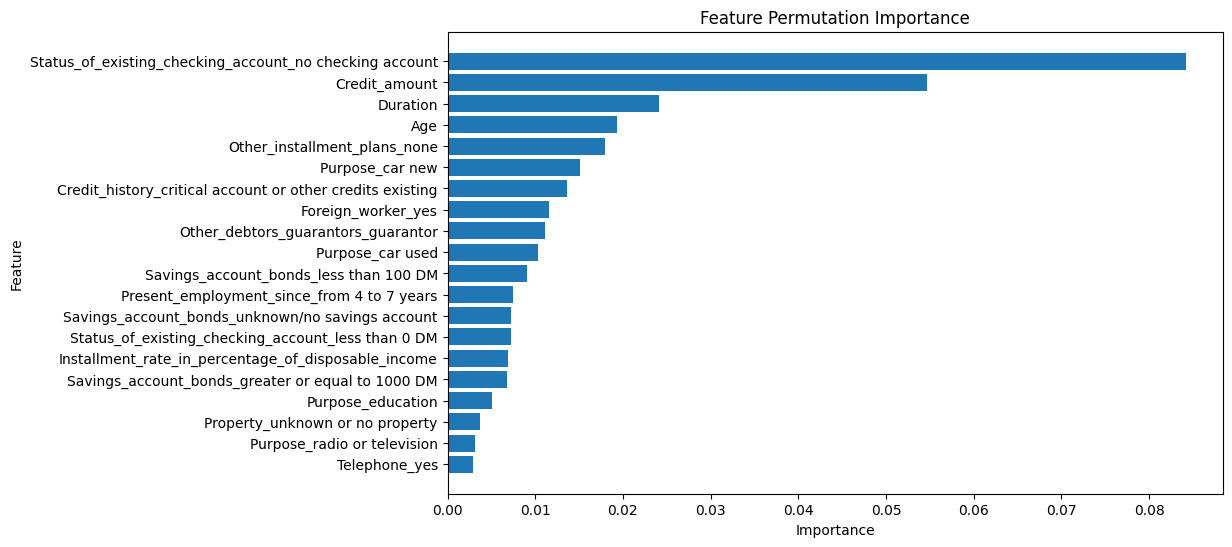

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_pl

In [ ]:
gbt2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  100   40  15      52.94   75.00        71.43      72.5     62.07   
1   51   69   71   9      41.80   85.00        49.29      60.0     56.04   
2   49   79   61  11      44.55   81.67        56.43      64.0     57.65   
3   50   65   75  10      40.00   83.33        46.43      57.5     54.05   
4   51   57   83   9      38.06   85.00        40.71      54.0     52.58   
5   50   60   80  10      38.46   83.33        42.86      55.0     52.63   
6   50   47   93  10      34.97   83.33        33.57      48.5     49.26   
7   50   39  101  10      33.11   83.33        27.86      44.5     47.39   
8   51   36  104   9      32.90   85.00        25.71      43.5     47.44   
9   53   33  107   7      33.12   88.33        23.57      43.0     48.18   
10  59   10  130   1      31.22   98.33         7.14      34.5     47.39   
11  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.21                 0   
1               67.14                 1   
2               69.05                 2   
3               64.88                 3   
4               62.86                 4   
5               63.10                 5   
6               58.45                 6   
7               55.60                 7   
8               55.36                 8   
9               55.95                 9   
10              52.74                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:45:59.547883

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
gbt2_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  100   40  15      52.94   75.00        71.43      72.5     62.07   
1   42   86   54  18      43.75   70.00        61.43      64.0     53.85   
2   40   82   58  20      40.82   66.67        58.57      61.0     50.63   
3   39   87   53  21      42.39   65.00        62.14      63.0     51.32   
4   38   81   59  22      39.18   63.33        57.86      59.5     48.41   
5   39   84   56  21      41.05   65.00        60.00      61.5     50.32   
6   39   80   60  21      39.39   65.00        57.14      59.5     49.06   
7   43   69   71  17      37.72   71.67        49.29      56.0     49.43   
8   45   67   73  15      38.14   75.00        47.86      56.0     50.56   
9   44   67   73  16      37.61   73.33        47.86      55.5     49.72   
10  52   39  101   8      33.99   86.67        27.86      45.5     48.83   
11  52   25  115   8      31.14   86.67        17.86      38.5     45.81   
12  50   31  109  10      31.45   83.33        22.14      40.5     45.66   
13  50   20  120  10      29.41   83.33        14.29      35.0     43.48   
14  47   35  105  13      30.92   78.33        25.00      41.0     44.34   
15  32   44   96  28      25.00   53.33        31.43      38.0     34.04   
16  37   52   88  23      29.60   61.67        37.14      44.5     40.00   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.21                 0   
1               65.71                 1   
2               62.62                 2   
3               63.57                 3   
4               60.60                 4   
5               62.50                 5   
6               61.07                 6   
7               60.48                 7   
8               61.43                 8   
9               60.60                 9   
10              57.26                10   
11              52.26                11   
12              52.74                12   
13              48.81                13   
14              51.67                14   
15              42.38                15   
16              49.40                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[10.0],
      'gamma': [0.0],
      'colsample_bytree':[0.25]
  }

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:48:49.256050

Nested Cross-validation Results:
Individual scores: [0.71428571 0.69791667 0.70535714 0.70238095 0.76488095]
Average nested CV score: 0.717 (+/- 0.049)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.717

Train score: 0.825
Test score: 0.717
Train-test score difference: 0.108
2025-01-19 00:48:50.177971

Execution time: 0.02 minutes


```
Starting hyperparameter tuning at: 2025-01-15 05:52:50.861565

Nested Cross-validation Results:
Individual scores: [0.71428571 0.64434524 0.70089286 0.72916667 0.72767857]
Average nested CV score: 0.703 (+/- 0.062)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.717

Train score: 0.825
Test score: 0.717
Train-test score difference: 0.108
2025-01-15 06:10:34.847234

Execution time: 17.73 minutes

```



In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
1                                       Credit_amount    0.055655  0.008263
11  Status_of_existing_checking_account_no checkin...    0.055119  0.005170
0                                            Duration    0.027202  0.008747
4                                                 Age    0.023155  0.005049
41                       Other_installment_plans_none    0.019524  0.007488
10  Status_of_existing_checking_account_less than ...    0.013690  0.004313
12  Credit_history_critical account or other credi...    0.010833  0.007469
36                 Other_debtors_guarantors_guarantor    0.010774  0.002230
27             Savings_account_bonds_less than 100 DM    0.010060  0.003488
17                                   Purpose_car used    0.009702  0.002310
8                                  Foreign_worker_yes    0.009643  0.002980
16                                    Purpose_car new    0.008810  0.003301
22                        Purpose_radio or television    0.007321  0.001711
3                             Present_residence_since    0.007143  0.002642
2   Installment_rate_in_percentage_of_disposable_i...    0.007024  0.003307
40                    Property_unknown or no property    0.006964  0.001453
19                                  Purpose_education    0.004940  0.000668
15  Credit_history_no credits taken or all credits...    0.004702  0.000714
7                                       Telephone_yes    0.004464  0.002588
29         Present_employment_since_from 4 to 7 years    0.004286  0.004528
28   Savings_account_bonds_unknown/no savings account    0.003869  0.002138
33  Personal_status_and_sex_male divorced or separ...    0.002857  0.004590
47                           Job_unskilled - resident    0.002857  0.001888
13     Credit_history_delay in paying off in the past    0.002679  0.001725
35                Personal_status_and_sex_male single    0.002619  0.005211
26  Savings_account_bonds_greater or equal to 1000 DM    0.002381  0.002560
5             Number_of_existing_credits_at_this_bank    0.002321  0.002549
38                              Property_car or other    0.001607  0.000875
43                                        Housing_own    0.001607  0.001658
6   Number_of_people_being_liable_to_provide_maint...    0.001429  0.001499
14  Credit_history_existing credits paid back duly...    0.001369  0.001679
31          Present_employment_since_less than 1 year    0.000893  0.004288
32                Present_employment_since_unemployed    0.000595  0.001815
45                   Job_skilled employee or official    0.000417  0.000694
20                     Purpose_furniture or equipment    0.000357  0.000437
23                                    Purpose_repairs    0.000238  0.001211
42                     Other_installment_plans_stores    0.000179  0.000357
9   Status_of_existing_checking_account_greater or...   -0.000119  0.002833
37                      Other_debtors_guarantors_none   -0.000357  0.000714
39                               Property_real estate   -0.002976  0.004912

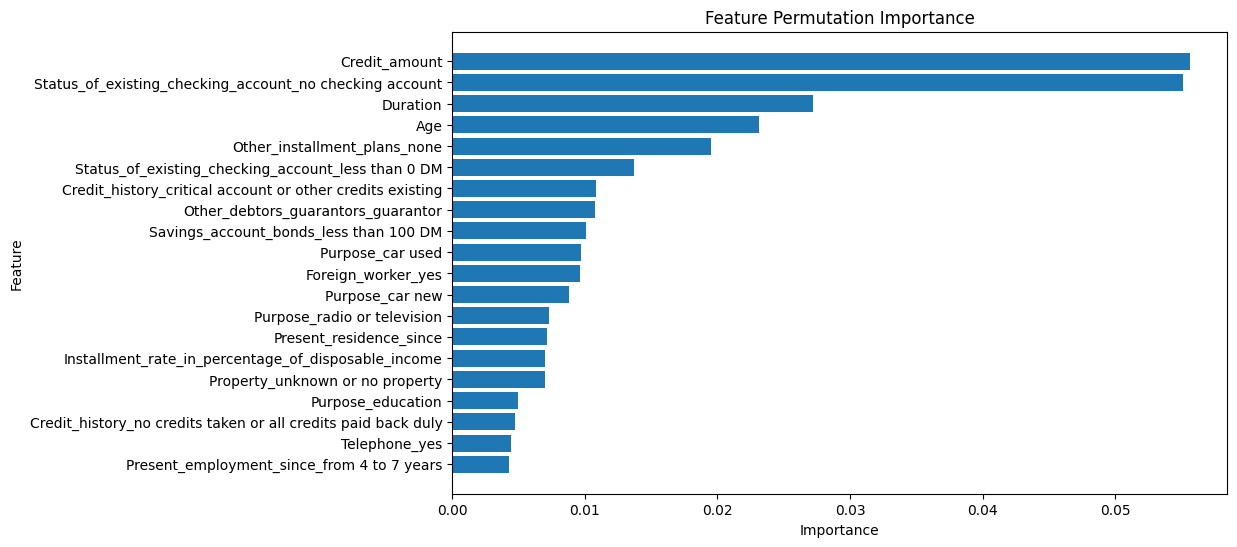

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Credit_amount']

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Credit_amount', 'Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Credit_amount', 'Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Credit_amount', 'Status_of_existing_checking_account', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_plans_stores']
Original 

In [ ]:
xgb2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41   96   44  19      48.24   68.33        68.57      68.5     56.55   
1   41  104   36  19      53.25   68.33        74.29      72.5     59.85   
2   44   87   53  16      45.36   73.33        62.14      65.5     56.05   
3   47   69   71  13      39.83   78.33        49.29      58.0     52.81   
4   47   67   73  13      39.17   78.33        47.86      57.0     52.22   
5   46   73   67  14      40.71   76.67        52.14      59.5     53.18   
6   48   54   86  12      35.82   80.00        38.57      51.0     49.48   
7   50   53   87  10      36.50   83.33        37.86      51.5     50.76   
8   53   38  102   7      34.19   88.33        27.14      45.5     49.30   
9   51   34  106   9      32.48   85.00        24.29      42.5     47.00   
10  53   32  108   7      32.92   88.33        22.86      42.5     47.96   
11  53   30  110   7      32.52   88.33        21.43      41.5     47.53   
12  55   22  118   5      31.79   91.67        15.71      38.5     47.21   
13  54   14  126   6      30.00   90.00        10.00      34.0     45.00   
14  56    5  135   4      29.32   93.33         3.57      30.5     44.62   
15  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               68.45                 0   
1               71.31                 1   
2               67.74                 2   
3               63.81                 3   
4               63.10                 4   
5               64.40                 5   
6               59.29                 6   
7               60.60                 7   
8               57.74                 8   
9               54.64                 9   
10              55.60                10   
11              54.88                11   
12              53.69                12   
13              50.00                13   
14              48.45                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                           ['Credit_amount'] imputed  
2   ['Credit_amount', 'Status_of_existing_checking...  
3   ['Credit_amount', 'Status_of_existing_checking...  
4   ['Credit_amount', 'Status_of_existing_checking...  
5   ['Credit_amount', 'Status_of_existing_checking...  
6   ['Credit_amount', 'Status_of_existing_checking...  
7   ['Credit_amount', 'Status_of_existing_checking...  
8   ['Credit_amount', 'Status_of_existing_checking...  
9   ['Credit_amount', 'Status_of_existing_checking...  
10  ['Credit_amount', 'Status_of_existing_checking...  
11  ['Credit_amount', 'Status_of_existing_checking...  
12  ['Credit_amount', 'Status_of_existing_checking...  
13  ['Credit_amount', 'Status_of_existing_checking...  
14  ['Credit_amount', 'Status_of_existing_checking...  
15  ['Credit_amount', 'Status_of_existing_checking...  
16  ['Credit_amount', 'Status_of_existing_checking...  
17  ['Credit_amount', 'Status_of_existing_checking...  
18  ['Credit_amount', 'Status_of_existing_checking...  
19  ['Credit_amount', 'Status_of_existing_checking...  
20  ['Credit_amount', 'Status_of_existing_checking...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:48:51.965442

--- NEW ITERATION ---
Removing feature:  Credit_amount
Nr. columns with nan:  1
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly', 'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_

In [ ]:
xgb2_perf_mf

tp   tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41   96  44  19      48.24   68.33        68.57      68.5     56.55   
1   38   97  43  22      46.91   63.33        69.29      67.5     53.90   
2   36   83  57  24      38.71   60.00        59.29      59.5     47.06   
3   37   89  51  23      42.05   61.67        63.57      63.0     50.00   
4   38   88  52  22      42.22   63.33        62.86      63.0     50.67   
5   37   95  45  23      45.12   61.67        67.86      66.0     52.11   
6   38   81  59  22      39.18   63.33        57.86      59.5     48.41   
7   40   82  58  20      40.82   66.67        58.57      61.0     50.63   
8   49   57  83  11      37.12   81.67        40.71      53.0     51.04   
9   49   54  86  11      36.30   81.67        38.57      51.5     50.26   
10  51   53  87   9      36.96   85.00        37.86      52.0     51.52   
11  48   58  82  12      36.92   80.00        41.43      53.0     50.53   
12  45   52  88  15      33.83   75.00        37.14      48.5     46.63   
13  41   50  90  19      31.30   68.33        35.71      45.5     42.93   
14  41   53  87  19      32.03   68.33        37.86      47.0     43.62   
15  41   50  90  19      31.30   68.33        35.71      45.5     42.93   
16  20   65  75  40      21.05   33.33        46.43      42.5     25.81   
17  15   80  60  45      20.00   25.00        57.14      47.5     22.22   
18  10  123  17  50      37.04   16.67        87.86      66.5     22.99   
19   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
20   0  140   0  60       0.00    0.00       100.00      70.0      0.00   

    balanced_accuracy  num_feat_missing  \
0               68.45                 0   
1               66.31                 1   
2               59.64                 2   
3               62.62                 3   
4               63.10                 4   
5               64.76                 5   
6               60.60                 6   
7               62.62                 7   
8               61.19                 8   
9               60.12                 9   
10              61.43                10   
11              60.71                11   
12              56.07                12   
13              52.02                13   
14              53.10                14   
15              52.02                15   
16              39.88                16   
17              41.07                17   
18              52.26                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                           ['Credit_amount'] imputed  
2   ['Credit_amount', 'Status_of_existing_checking...  
3   ['Credit_amount', 'Status_of_existing_checking...  
4   ['Credit_amount', 'Status_of_existing_checking...  
5   ['Credit_amount', 'Status_of_existing_checking...  
6   ['Credit_amount', 'Status_of_existing_checking...  
7   ['Credit_amount', 'Status_of_existing_checking...  
8   ['Credit_amount', 'Status_of_existing_checking...  
9   ['Credit_amount', 'Status_of_existing_checking...  
10  ['Credit_amount', 'Status_of_existing_checking...  
11  ['Credit_amount', 'Status_of_existing_checking...  
12  ['Credit_amount', 'Status_of_existing_checking...  
13  ['Credit_amount', 'Status_of_existing_checking...  
14  ['Credit_amount', 'Status_of_existing_checking...  
15  ['Credit_amount', 'Status_of_existing_checking...  
16  ['Credit_amount', 'Status_of_existing_checking...  
17  ['Credit_amount', 'Status_of_existing_checking...  
18  ['Credit_amount', 'Status_of_existing_checking...  
19  ['Credit_amount', 'Status_of_existing_checking...  
20  ['Credit_amount', 'Status_of_existing_checking...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.05, 0.01, 2],
      'min_samples_leaf': [0.05, 0.01, 1]
  }
else:
  et2_param_grid = {
    'n_estimators': [500],
    'max_depth': [2],
    'max_features':['sqrt'],
    'min_samples_split': [0.05],
    'min_samples_leaf': [0.01],
}

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:51:41.648692

Nested Cross-validation Results:
Individual scores: [0.63392857 0.69642857 0.7514881  0.76041667 0.7485119 ]
Average nested CV score: 0.718 (+/- 0.095)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.05, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.718

Train score: 0.730
Test score: 0.718
Train-test score difference: 0.012
2025-01-19 00:51:49.665795

Execution time: 0.13 minutes


```
Starting hyperparameter tuning at: 2025-01-15 06:10:34.856388

Nested Cross-validation Results:
Individual scores: [0.61011905 0.67708333 0.72619048 0.68154762 0.71130952]
Average nested CV score: 0.681 (+/- 0.080)

Fitting final model on entire dataset...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.05, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.718

Train score: 0.730
Test score: 0.718
Train-test score difference: 0.012
2025-01-15 06:37:12.190441

Execution time: 26.62 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.074583  0.012720
39                               Property_real estate    0.013988  0.002861
10  Status_of_existing_checking_account_less than ...    0.005655  0.003249
28   Savings_account_bonds_unknown/no savings account    0.005595  0.003129
12  Credit_history_critical account or other credi...    0.005060  0.009345
27             Savings_account_bonds_less than 100 DM    0.003631  0.006889
41                       Other_installment_plans_none    0.003274  0.003807
8                                  Foreign_worker_yes    0.002976  0.001145
25          Savings_account_bonds_from 500 to 1000 DM    0.002857  0.002143
4                                                 Age    0.002500  0.000833
22                        Purpose_radio or television    0.001905  0.002076
3                             Present_residence_since    0.001667  0.000833
42                     Other_installment_plans_stores    0.001250  0.001021
6   Number_of_people_being_liable_to_provide_maint...    0.000833  0.001021
2   Installment_rate_in_percentage_of_disposable_i...    0.000833  0.001021
26  Savings_account_bonds_greater or equal to 1000 DM    0.000774  0.000952
37                      Other_debtors_guarantors_none    0.000417  0.000833
47                           Job_unskilled - resident    0.000417  0.000833
0                                            Duration    0.000060  0.004554
17                                   Purpose_car used   -0.000238  0.001451
13     Credit_history_delay in paying off in the past   -0.000357  0.000437
33  Personal_status_and_sex_male divorced or separ...   -0.000417  0.000833
32                Present_employment_since_unemployed   -0.000417  0.000833
40                    Property_unknown or no property   -0.000476  0.003494
1                                       Credit_amount   -0.000595  0.002282
36                 Other_debtors_guarantors_guarantor   -0.000655  0.001136
9   Status_of_existing_checking_account_greater or...   -0.001250  0.001667
16                                    Purpose_car new   -0.001310  0.001821
43                                        Housing_own   -0.001369  0.001869
35                Personal_status_and_sex_male single   -0.001667  0.001559
15  Credit_history_no credits taken or all credits...   -0.001845  0.001426
31          Present_employment_since_less than 1 year   -0.004167  0.001910

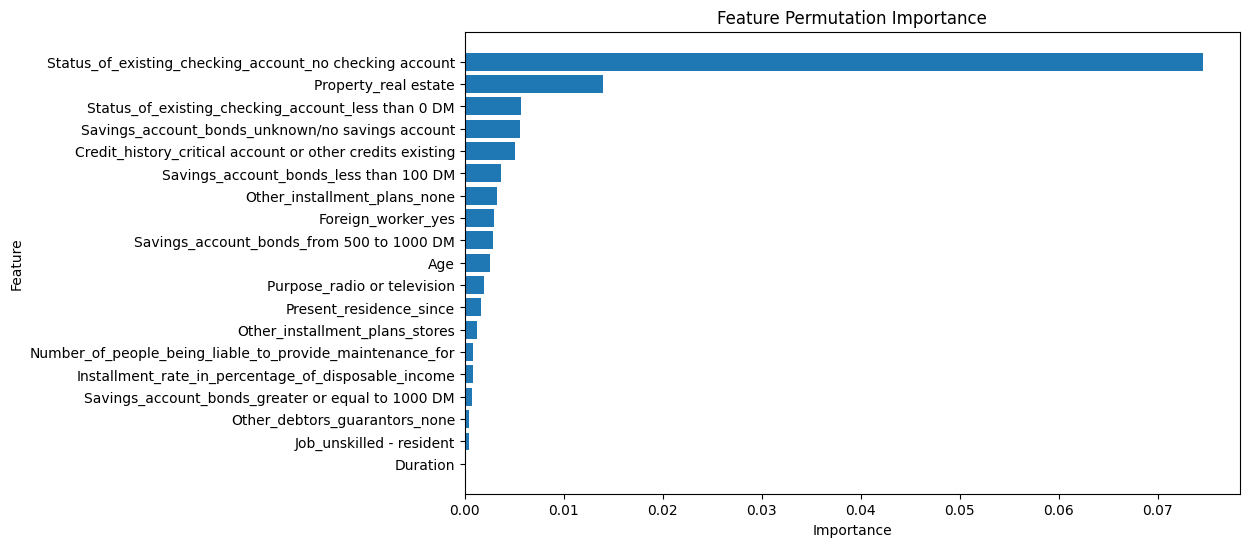

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Property_real estate
Removing related features:  ['Property_car or other', 'Property_real estate', 'Property_unknown or no property']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Property']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_unknown/no savings account
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Origina

In [ ]:
et2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  91   49  11      50.00   81.67        65.00      70.0     62.03   
1   51  62   78   9      39.53   85.00        44.29      56.5     53.97   
2   52  56   84   8      38.24   86.67        40.00      54.0     53.06   
3   59  33  107   1      35.54   98.33        23.57      46.0     52.21   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.33                 0   
1               64.64                 1   
2               63.33                 2   
3               60.95                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:51:56.202142

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
et2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  91   49  11      50.00   81.67        65.00      70.0     62.03   
1   42  76   64  18      39.62   70.00        54.29      59.0     50.60   
2   44  69   71  16      38.26   73.33        49.29      56.5     50.29   
3   52  38  102   8      33.77   86.67        27.14      45.0     48.60   
4   51  20  120   9      29.82   85.00        14.29      35.5     44.16   
5   52  21  119   8      30.41   86.67        15.00      36.5     45.02   
6   52  22  118   8      30.59   86.67        15.71      37.0     45.22   
7   52  22  118   8      30.59   86.67        15.71      37.0     45.22   
8   48  27  113  12      29.81   80.00        19.29      37.5     43.44   
9   48  27  113  12      29.81   80.00        19.29      37.5     43.44   
10  48  27  113  12      29.81   80.00        19.29      37.5     43.44   
11  50  28  112  10      30.86   83.33        20.00      39.0     45.05   
12  50  32  108  10      31.65   83.33        22.86      41.0     45.87   
13  52  34  106   8      32.91   86.67        24.29      43.0     47.71   
14  52  34  106   8      32.91   86.67        24.29      43.0     47.71   
15  51  36  104   9      32.90   85.00        25.71      43.5     47.44   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.33                 0   
1               62.14                 1   
2               61.31                 2   
3               56.90                 3   
4               49.64                 4   
5               50.83                 5   
6               51.19                 6   
7               51.19                 7   
8               49.64                 8   
9               49.64                 9   
10              49.64                10   
11              51.67                11   
12              53.10                12   
13              55.48                13   
14              55.48                14   
15              55.36                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [0.1],
    'kernel': ['poly'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 5, 5, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:54:46.886657

Nested Cross-validation Results:
Individual scores: [0.63095238 0.73809524 0.74404762 0.75297619 0.75      ]
Average nested CV score: 0.723 (+/- 0.093)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.723

Train score: 0.747
Test score: 0.723
Train-test score difference: 0.023
2025-01-19 00:54:47.230860

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-15 06:37:12.197688

Nested Cross-validation Results:
Individual scores: [0.6235119  0.61904762 0.71428571 0.74404762 0.7485119 ]
Average nested CV score: 0.690 (+/- 0.115)

Fitting final model on entire dataset...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.723

Train score: 0.747
Test score: 0.723
Train-test score difference: 0.023
2025-01-15 06:38:27.143923

Execution time: 1.25 minutes
```





In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.068452  0.005089
41                       Other_installment_plans_none    0.018036  0.002256
22                        Purpose_radio or television    0.011845  0.004669
0                                            Duration    0.008750  0.002639
27             Savings_account_bonds_less than 100 DM    0.007143  0.003167
10  Status_of_existing_checking_account_less than ...    0.006548  0.007506
39                               Property_real estate    0.005833  0.004393
14  Credit_history_existing credits paid back duly...    0.005119  0.002611
28   Savings_account_bonds_unknown/no savings account    0.004702  0.004863
38                              Property_car or other    0.004702  0.002285
29         Present_employment_since_from 4 to 7 years    0.003869  0.003161
42                     Other_installment_plans_stores    0.003869  0.001873
45                   Job_skilled employee or official    0.003810  0.002254
35                Personal_status_and_sex_male single    0.003631  0.003473
26  Savings_account_bonds_greater or equal to 1000 DM    0.003512  0.001211
12  Credit_history_critical account or other credi...    0.003095  0.001525
1                                       Credit_amount    0.002679  0.001597
3                             Present_residence_since    0.002500  0.003879
31          Present_employment_since_less than 1 year    0.002262  0.002168
7                                       Telephone_yes    0.001964  0.002325
36                 Other_debtors_guarantors_guarantor    0.001905  0.001570
32                Present_employment_since_unemployed    0.001786  0.001304
30  Present_employment_since_greater or equal to 7...    0.001667  0.000552
33  Personal_status_and_sex_male divorced or separ...    0.001607  0.001185
17                                   Purpose_car used    0.001548  0.003327
2   Installment_rate_in_percentage_of_disposable_i...    0.001250  0.003752
8                                  Foreign_worker_yes    0.001250  0.000437
9   Status_of_existing_checking_account_greater or...    0.001250  0.000911
4                                                 Age    0.001071  0.002393
37                      Other_debtors_guarantors_none    0.001071  0.000668
40                    Property_unknown or no property    0.001071  0.002363
6   Number_of_people_being_liable_to_provide_maint...    0.001012  0.001604
34    Personal_status_and_sex_male married or widowed    0.000833  0.001021
13     Credit_history_delay in paying off in the past    0.000536  0.000437
44                                       Housing_rent    0.000357  0.000437
23                                    Purpose_repairs    0.000179  0.000668
15  Credit_history_no credits taken or all credits...    0.000060  0.000985
19                                  Purpose_education   -0.000357  0.000714
20                     Purpose_furniture or equipment   -0.000357  0.000714
47                           Job_unskilled - resident   -0.000357  0.002698
16                                    Purpose_car new   -0.000476  0.002325
25          Savings_account_bonds_from 500 to 1000 DM   -0.001131  0.000663
43                                        Housing_own   -0.005179  0.002248

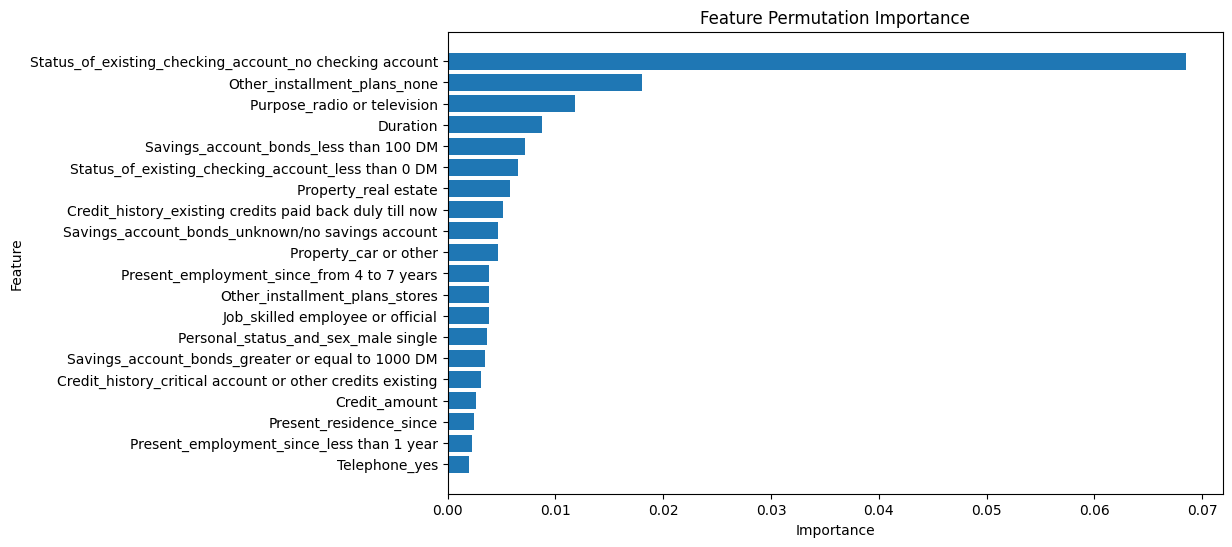

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_plans_stores']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Other_installment_plans']

--- NEW ITERATION ---
Removing feature:  Purpose_radio or television
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed s

In [ ]:
svm2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   48  87   53  12      47.52   80.00        62.14      67.5     59.63   
1   56  49   91   4      38.10   93.33        35.00      52.5     54.11   
2   54  55   85   6      38.85   90.00        39.29      54.5     54.27   
3   55  44   96   5      36.42   91.67        31.43      49.5     52.13   
4   54  44   96   6      36.00   90.00        31.43      49.0     51.43   
5   55  22  118   5      31.79   91.67        15.71      38.5     47.21   
6   59  23  117   1      33.52   98.33        16.43      41.0     50.00   
7   60   3  137   0      30.46  100.00         2.14      31.5     46.69   
8   60   3  137   0      30.46  100.00         2.14      31.5     46.69   
9   60   1  139   0      30.15  100.00         0.71      30.5     46.33   
10  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
11  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
12  60   2  138   0      30.30  100.00         1.43      31.0     46.51   
13  60   2  138   0      30.30  100.00         1.43      31.0     46.51   
14  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               71.07                 0   
1               64.17                 1   
2               64.64                 2   
3               61.55                 3   
4               60.71                 4   
5               53.69                 5   
6               57.38                 6   
7               51.07                 7   
8               51.07                 8   
9               50.36                 9   
10              50.36                10   
11              50.36                11   
12              50.71                12   
13              50.71                13   
14              50.36                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:54:49.142406

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
svm2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   48  87   53  12      47.52   80.00        62.14      67.5     59.63   
1   44  71   69  16      38.94   73.33        50.71      57.5     50.87   
2   43  73   67  17      39.09   71.67        52.14      58.0     50.59   
3   43  67   73  17      37.07   71.67        47.86      55.0     48.86   
4   43  67   73  17      37.07   71.67        47.86      55.0     48.86   
5   50  37  103  10      32.68   83.33        26.43      43.5     46.95   
6   52  32  108   8      32.50   86.67        22.86      42.0     47.27   
7   48  24  116  12      29.27   80.00        17.14      36.0     42.86   
8   55   5  135   5      28.95   91.67         3.57      30.0     44.00   
9   59   7  133   1      30.73   98.33         5.00      33.0     46.83   
10  60   4  136   0      30.61  100.00         2.86      32.0     46.88   
11  60   4  136   0      30.61  100.00         2.86      32.0     46.88   
12  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
13  58   3  137   2      29.74   96.67         2.14      30.5     45.49   
14  58   4  136   2      29.90   96.67         2.86      31.0     45.67   
15  58   3  137   2      29.74   96.67         2.14      30.5     45.49   
16  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               71.07                 0   
1               62.02                 1   
2               61.90                 2   
3               59.76                 3   
4               59.76                 4   
5               54.88                 5   
6               54.76                 6   
7               48.57                 7   
8               47.62                 8   
9               51.67                 9   
10              51.43                10   
11              51.43                11   
12              50.36                12   
13              49.40                13   
14              49.76                14   
15              49.40                15   
16              50.36                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm for optimization
  }
else:
  # best model
  lr2_param_grid = {
    'C': [1.0],
    'penalty': ['l1'],
    'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 5, 5, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:57:40.733526

Nested Cross-validation Results:
Individual scores: [0.70089286 0.70238095 0.72172619 0.77380952 0.77083333]
Average nested CV score: 0.734 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.734

Train score: 0.765
Test score: 0.734
Train-test score difference: 0.031
2025-01-19 00:57:41.051453

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-15 06:38:27.151679

Nested Cross-validation Results:
Individual scores: [0.63244048 0.68005952 0.72172619 0.73660714 0.76785714]
Average nested CV score: 0.708 (+/- 0.094)

Fitting final model on entire dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.734

Train score: 0.765
Test score: 0.734
Train-test score difference: 0.031
2025-01-15 06:38:31.646724

Execution time: 0.07 minutes
```




In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0   Status_of_existing_checking_account_no checkin...    0.060357  0.009100
4   Credit_history_critical account or other credi...    0.025179  0.005987
3                                       Credit_amount    0.022024  0.008401
6                        Other_installment_plans_none    0.021905  0.005689
16                                                Age    0.016131  0.004745
26  Installment_rate_in_percentage_of_disposable_i...    0.015119  0.007682
23                 Other_debtors_guarantors_guarantor    0.013274  0.003619
32  Credit_history_existing credits paid back duly...    0.012500  0.003238
9    Savings_account_bonds_unknown/no savings account    0.008810  0.005319
46     Credit_history_delay in paying off in the past    0.008571  0.004240
14                                 Foreign_worker_yes    0.008333  0.001129
22         Present_employment_since_from 4 to 7 years    0.008036  0.004188
2                                            Duration    0.007738  0.011182
25                Personal_status_and_sex_male single    0.006726  0.004385
5              Savings_account_bonds_less than 100 DM    0.006667  0.003947
15                                    Purpose_car new    0.005774  0.003448
19  Savings_account_bonds_greater or equal to 1000 DM    0.004762  0.002388
1   Status_of_existing_checking_account_less than ...    0.004524  0.003850
17                                   Purpose_car used    0.004464  0.002904
29                                    Purpose_repairs    0.004464  0.001234
28                           Job_unskilled - resident    0.004167  0.004717
18  Personal_status_and_sex_male divorced or separ...    0.004048  0.001091
38                                     Purpose_others    0.002024  0.002590
36    Personal_status_and_sex_male married or widowed    0.001786  0.001844
12          Present_employment_since_less than 1 year    0.001488  0.001552
8                                Property_real estate    0.000476  0.005954
20          Savings_account_bonds_from 500 to 1000 DM    0.000417  0.000833
45  Number_of_people_being_liable_to_provide_maint...    0.000357  0.002285
31  Status_of_existing_checking_account_greater or...    0.000298  0.002053
44                      Other_debtors_guarantors_none    0.000179  0.003402
24                Present_employment_since_unemployed   -0.000179  0.001091
11                        Purpose_radio or television   -0.000238  0.002270
27                                  Purpose_education   -0.000476  0.002415
41                   Job_skilled employee or official   -0.001190  0.001873
40                                      Telephone_yes   -0.001250  0.004804
13                                        Housing_own   -0.001905  0.003274
7                     Property_unknown or no property   -0.002738  0.002166
35            Number_of_existing_credits_at_this_bank   -0.003571  0.002490

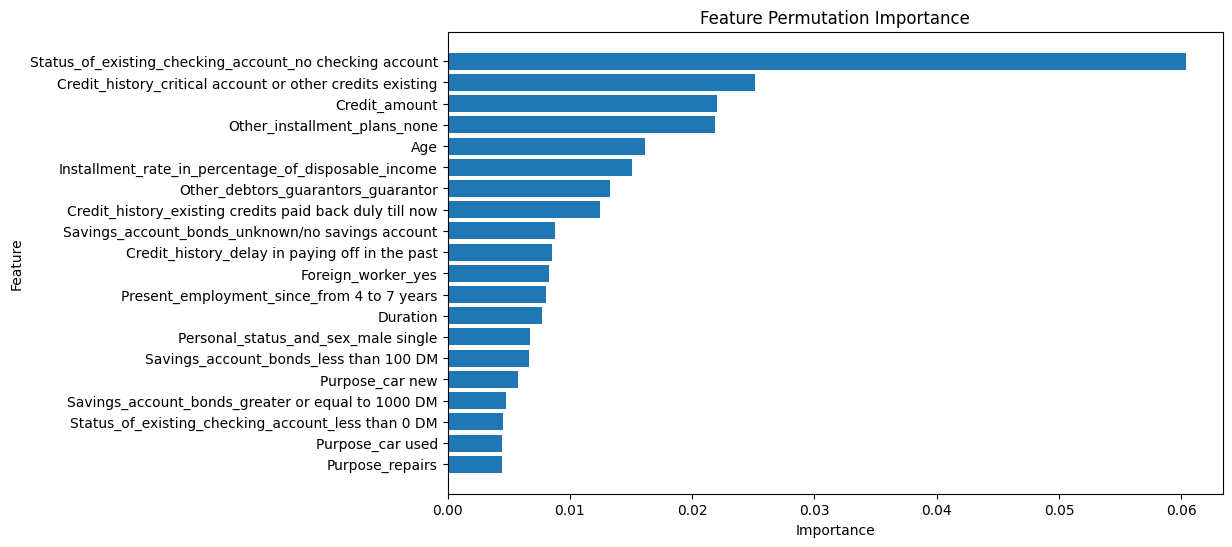

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_history_critical account or other credits existing
Removing related features:  ['Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_history']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_history', 'Cr

In [ ]:
lr2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   44  98   42  16      51.16   73.33        70.00      71.0     60.27   
1   49  75   65  11      42.98   81.67        53.57      62.0     56.32   
2   50  66   74  10      40.32   83.33        47.14      58.0     54.35   
3   49  70   70  11      41.18   81.67        50.00      59.5     54.75   
4   45  81   59  15      43.27   75.00        57.86      63.0     54.88   
5   44  81   59  16      42.72   73.33        57.86      62.5     53.99   
6   45  80   60  15      42.86   75.00        57.14      62.5     54.55   
7   46  80   60  14      43.40   76.67        57.14      63.0     55.42   
8   49  59   81  11      37.69   81.67        42.14      54.0     51.58   
9   51  55   85   9      37.50   85.00        39.29      53.0     52.04   
10  52  47   93   8      35.86   86.67        33.57      49.5     50.73   
11  51  46   94   9      35.17   85.00        32.86      48.5     49.76   
12  44  61   79  16      35.77   73.33        43.57      52.5     48.09   
13  42  66   74  18      36.21   70.00        47.14      54.0     47.73   
14  42  67   73  18      36.52   70.00        47.86      54.5     48.00   
15  37  59   81  23      31.36   61.67        42.14      48.0     41.57   
16  37  63   77  23      32.46   61.67        45.00      50.0     42.53   
17  37  63   77  23      32.46   61.67        45.00      50.0     42.53   
18  37  64   76  23      32.74   61.67        45.71      50.5     42.77   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               71.67                 0   
1               67.62                 1   
2               65.24                 2   
3               65.83                 3   
4               66.43                 4   
5               65.60                 5   
6               66.07                 6   
7               66.90                 7   
8               61.90                 8   
9               62.14                 9   
10              60.12                10   
11              58.93                11   
12              58.45                12   
13              58.57                13   
14              58.93                14   
15              51.90                15   
16              53.33                16   
17              53.33                17   
18              53.69                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=lr_german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:57:42.201624

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Age', 'Installment_rate_in_percentage_of_disposable_income', 'Number_of_existing_credits_at_this_bank', 'Present_residence_since']
Categorical columns:  ['Status_of_existing_checking_account_no checking account', 'Status_of_existing_checking_account_less than 0 DM', 'Credit_history_critical account or other credits existing', 'Savings_account_bonds_less than 100 DM', 'Other_installment_plans_none', 'Property_unknown or no property', 'Property_real estate', 'Savings_account_bonds_unknown/no savings account', 'Credit_history_no credits taken or all credits paid bac

In [ ]:
lr2_perf_mf

tp   tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   44   98  42  16      51.16   73.33        70.00      71.0     60.27   
1   36  105  35  24      50.70   60.00        75.00      70.5     54.96   
2   34   97  43  26      44.16   56.67        69.29      65.5     49.64   
3   33   94  46  27      41.77   55.00        67.14      63.5     47.48   
4   30   97  43  30      41.10   50.00        69.29      63.5     45.11   
5   29  102  38  31      43.28   48.33        72.86      65.5     45.67   
6   30  105  35  30      46.15   50.00        75.00      67.5     48.00   
7   30  105  35  30      46.15   50.00        75.00      67.5     48.00   
8   37   92  48  23      43.53   61.67        65.71      64.5     51.03   
9   39   91  49  21      44.32   65.00        65.00      65.0     52.70   
10  34   83  57  26      37.36   56.67        59.29      58.5     45.03   
11  31   87  53  29      36.90   51.67        62.14      59.0     43.06   
12  27   92  48  33      36.00   45.00        65.71      59.5     40.00   
13  25   88  52  35      32.47   41.67        62.86      56.5     36.50   
14  28   95  45  32      38.36   46.67        67.86      61.5     42.11   
15  25  106  34  35      42.37   41.67        75.71      65.5     42.02   
16  27  105  35  33      43.55   45.00        75.00      66.0     44.26   
17  25  115  25  35      50.00   41.67        82.14      70.0     45.45   
18   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
19   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
20   0  140   0  60       0.00    0.00       100.00      70.0      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.67                 0   
1               67.50                 1   
2               62.98                 2   
3               61.07                 3   
4               59.64                 4   
5               60.60                 5   
6               62.50                 6   
7               62.50                 7   
8               63.69                 8   
9               65.00                 9   
10              57.98                10   
11              56.90                11   
12              55.36                12   
13              52.26                13   
14              57.26                14   
15              58.69                15   
16              60.00                16   
17              61.90                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

# **Results comparison**

## **F1-score**

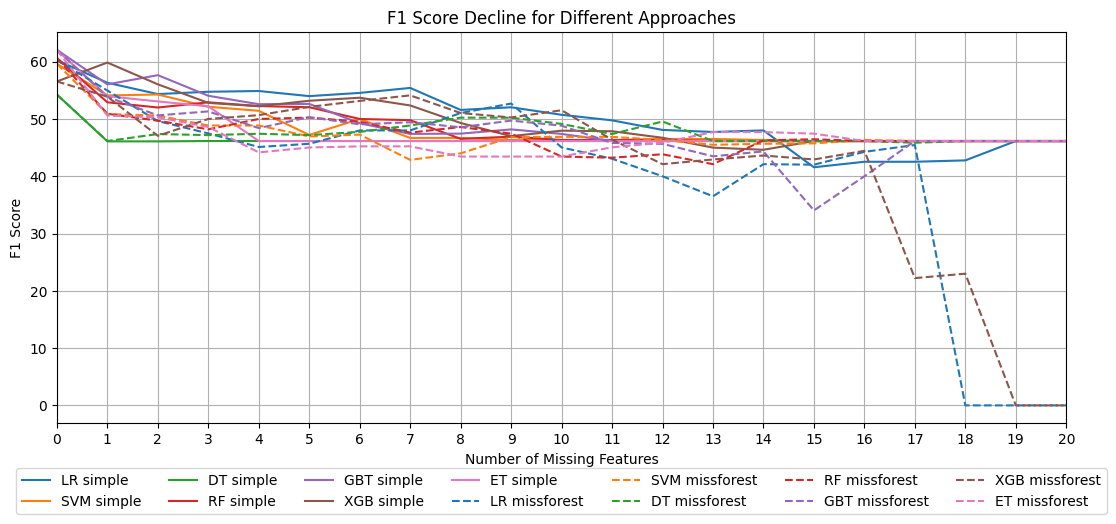

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

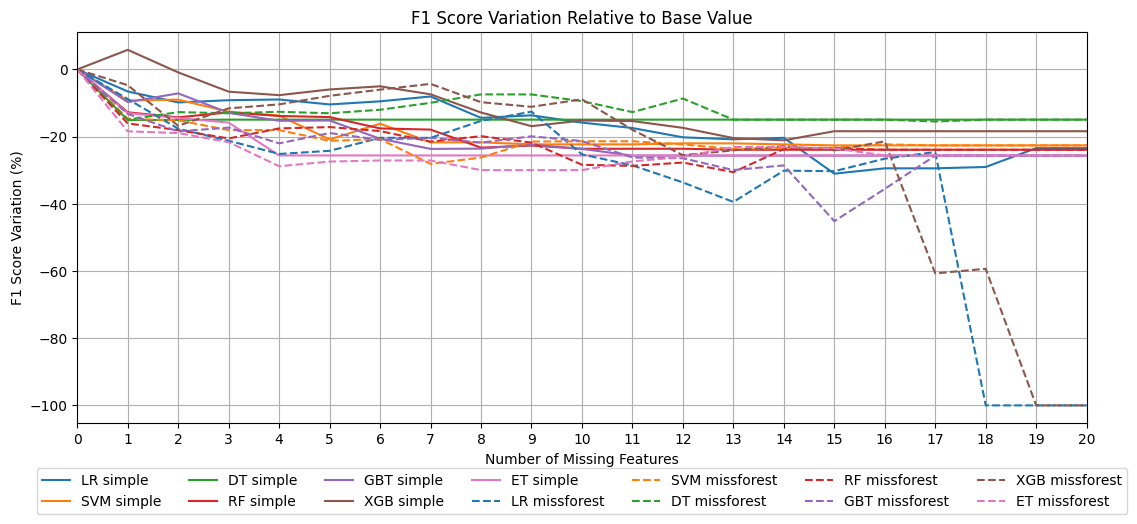

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

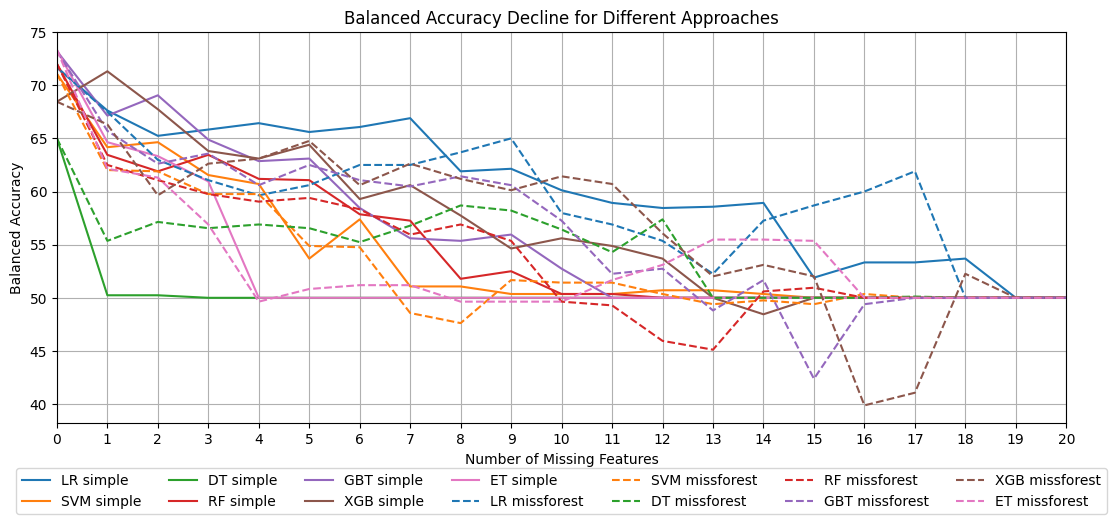

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

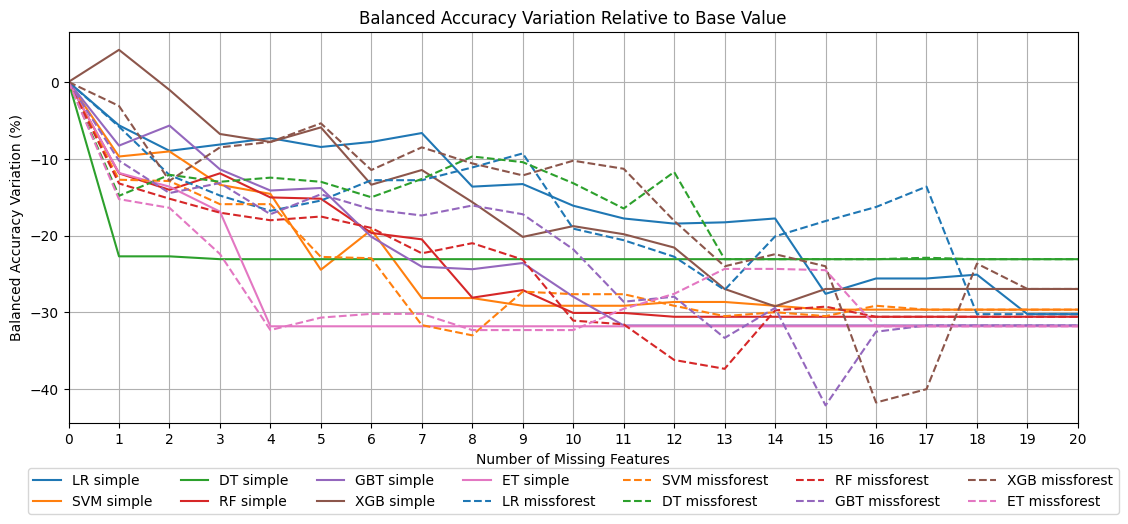

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict, 'German Credit', 'Scenario 1: standard', RANDOM_STATE
)
save_dataset(all_data, 'german_credit_scenario1_seed_1981.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    44  98   42  16      51.16   73.33        70.00      71.0     60.27   
1    49  75   65  11      42.98   81.67        53.57      62.0     56.32   
2    50  66   74  10      40.32   83.33        47.14      58.0     54.35   
3    49  70   70  11      41.18   81.67        50.00      59.5     54.75   
4    45  81   59  15      43.27   75.00        57.86      63.0     54.88   
..   ..  ..  ...  ..        ...     ...          ...       ...       ...   
583  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
584  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
585  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
586  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
587  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

     balanced_accuracy  num_feat_missing  \
0                71.67                 0   
1                67.62                 1   
2                65.24                 2   
3                65.83                 3   
4                66.43                 4   
..                 ...               ...   
583              50.00                16   
584              50.00                17   
585              50.00                18   
586              50.00                19   
587              50.00                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1    ['Status_of_existing_checking_account_greater ...      lr_perf   
2    ['Status_of_existing_checking_account_greater ...      lr_perf   
3    ['Status_of_existing_checking_account_greater ...      lr_perf   
4    ['Status_of_existing_checking_account_greater ...      lr_perf   
..                                                 ...          ...   
583  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
584  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
585  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
586  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
587  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   

            source              scenario  random_state             metric  
0    German Credit  Scenario 1: standard          1981           f1 score  
1    German Credit  Scenario 1: standard          1981           f1 score  
2    German Credit  Scenario 1: standard          1981           f1 score  
3    German Credit  Scenario 1: standard          1981           f1 score  
4    German Credit  Scenario 1: standard          1981           f1 score  
..             ...                   ...           ...                ...  
583  German Credit  Scenario 1: standard          1981  balanced accuracy  
584  German Credit  Scenario 1: standard          1981  balanced accuracy  
585  German Credit  Scenario 1: standard          1981  balanced accuracy  
586  German Credit  Scenario 1: standard          1981  balanced accuracy  
587  German Credit  Scenario 1: standard          1981  balanced accuracy  

[588 rows x 17 columns]